## RUL prediction using Long Short Term Memory (LSTM) network

In this notebook, we will use LSTM to predict RUL of NASA's turbofan engine dataset FD001. We will show the implementation without going into the theory of LSTM. Readers who want to get an intuitive understanding of LSTMs, should read [this excellent blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random
import os

# 固定 SEED
SEED = 42

# 固定 Python 內建的隨機數
random.seed(SEED)

# 固定 NumPy 的隨機數
np.random.seed(SEED)

# 固定 TensorFlow 的隨機數
tf.random.set_seed(SEED)

# 確保 TensorFlow 在單執行緒模式下運行（避免 GPU 影響）
os.environ['TF_DETERMINISTIC_OPS'] = '1'

2025-02-18 18:16:14.121890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-18 18:16:14.992422: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-18 18:16:14.992542: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-18 18:16:14.992552: W tensorflow/compiler/tf2tensorrt/util

In [2]:
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.11.1
Numpy version:  1.26.4
Pandas version:  2.0.3
Scikit-learn version:  1.3.2


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: Standard scaling and Full dataset scaling.

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate. 

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly. 

In [3]:
CMAPSSData_path = "../../../__datasets/CMAPSSData/"

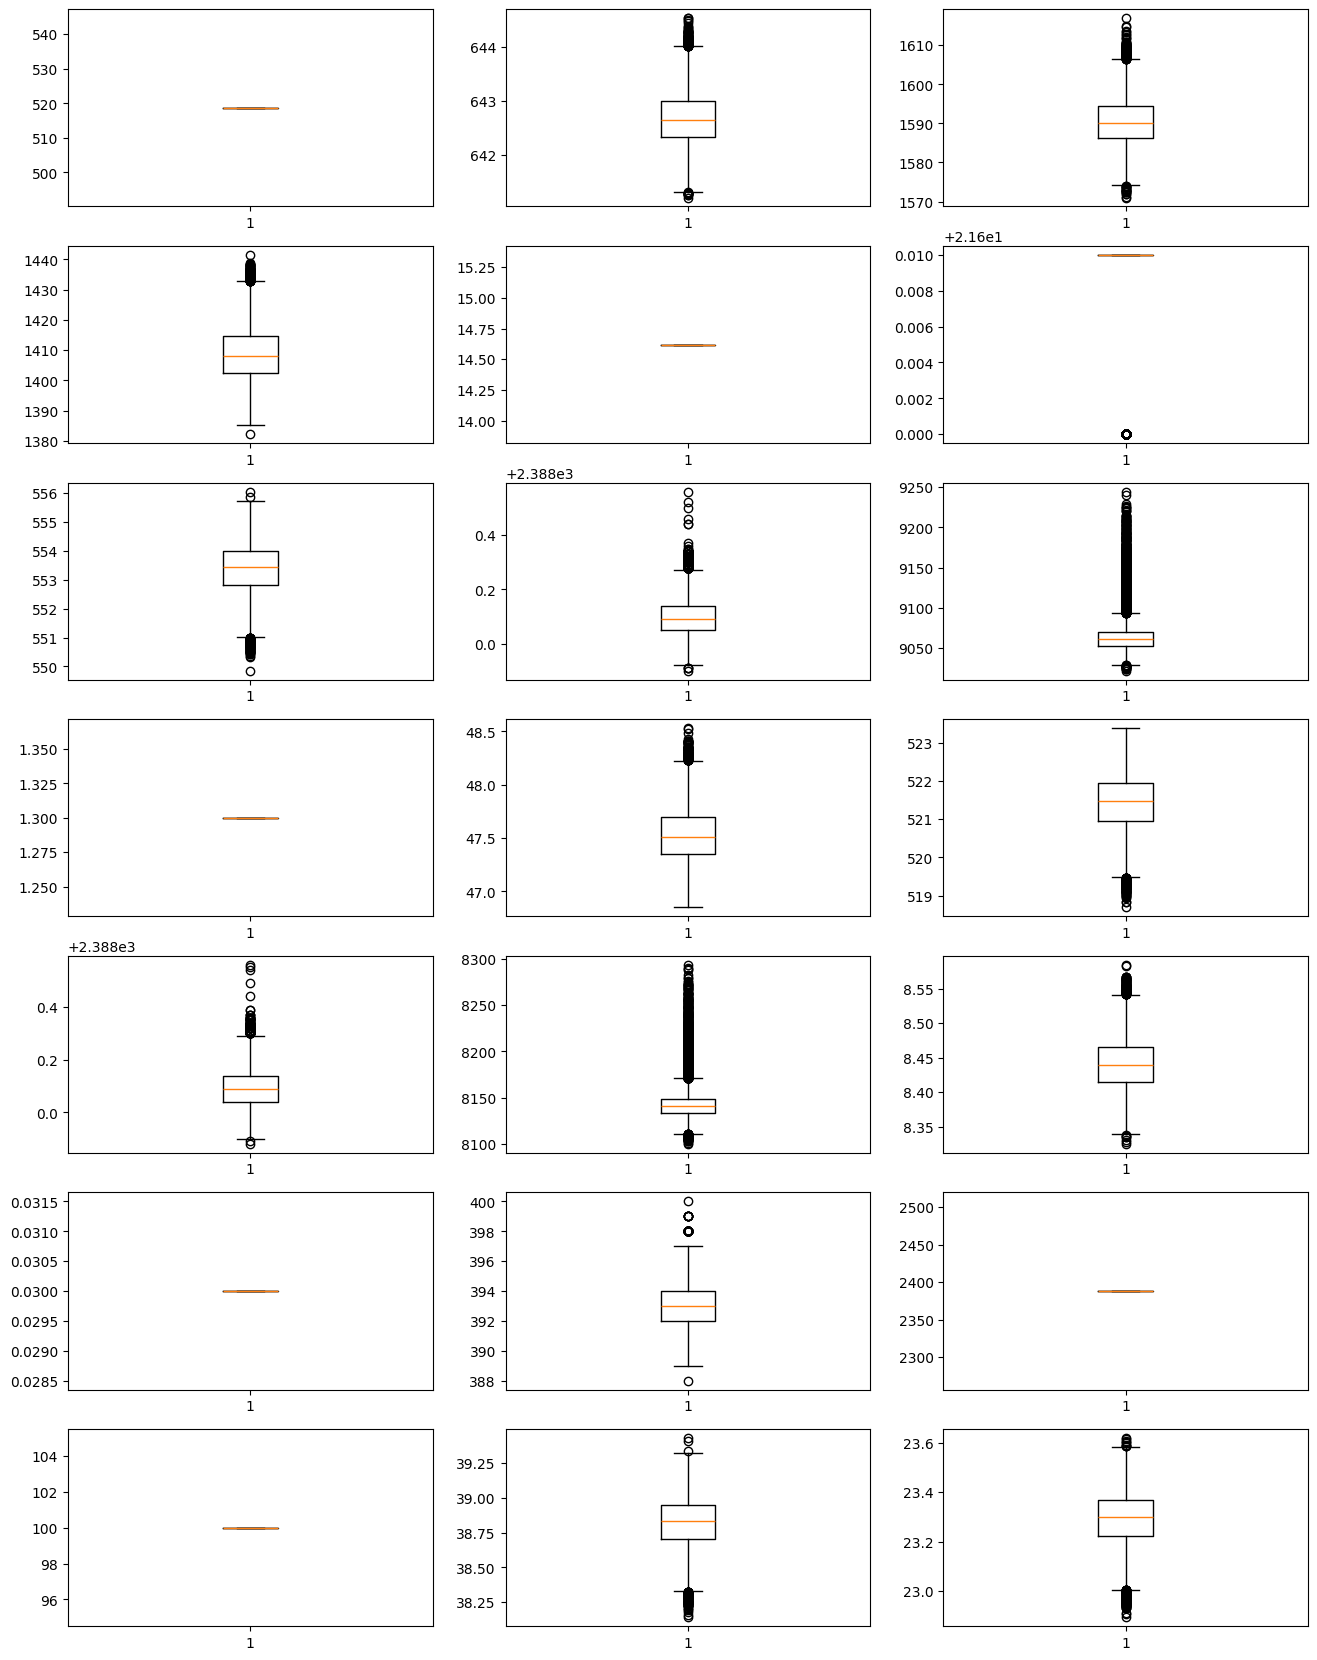

In [4]:
train_data = pd.read_csv(CMAPSSData_path+"/train_FD001.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [5]:
num_cycles_to_failure = train_data.groupby(0)[1].count()
num_cycles_to_failure.values

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200])

In [6]:
num_cycles_to_failure.values.shape[0]

100

In [7]:
num_cycles_to_failure.values.max()

362

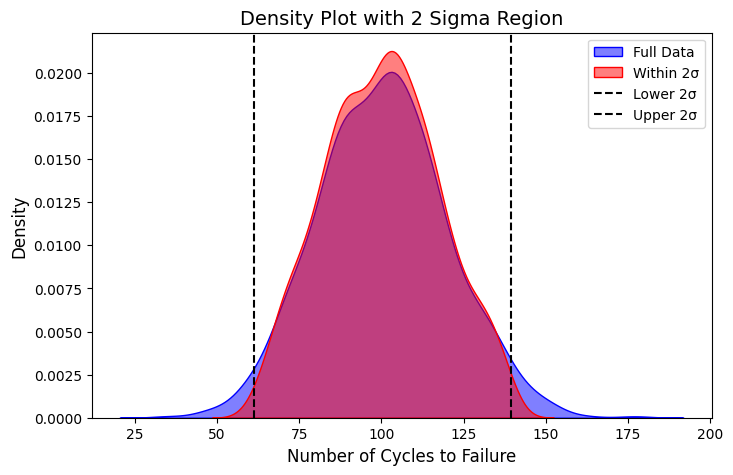

2σ 範圍：[61.24, 139.54]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假設 num_cycles_to_failure 是 numpy 陣列
num_cycles_to_failure = np.random.normal(loc=100, scale=20, size=1000)  # 示例數據

# 計算均值 & 標準差
mean = np.mean(num_cycles_to_failure)
std = np.std(num_cycles_to_failure)

# 計算 2 sigma 範圍
lower_bound = mean - 2 * std
upper_bound = mean + 2 * std

# 選出落在 2 sigma 內的數據
within_2sigma = num_cycles_to_failure[(num_cycles_to_failure >= lower_bound) & (num_cycles_to_failure <= upper_bound)]

# 繪製密度圖
plt.figure(figsize=(8, 5))
sns.kdeplot(num_cycles_to_failure, fill=True, color="blue", alpha=0.5, label="Full Data")
sns.kdeplot(within_2sigma, fill=True, color="red", alpha=0.5, label="Within 2σ")

# 標記 2 sigma 範圍
plt.axvline(lower_bound, color='black', linestyle='dashed', label="Lower 2σ")
plt.axvline(upper_bound, color='black', linestyle='dashed', label="Upper 2σ")

# 標題 & 標籤
plt.title("Density Plot with 2 Sigma Region", fontsize=14)
plt.xlabel("Number of Cycles to Failure", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()

# 顯示圖表
plt.show()

# 印出範圍
print(f"2σ 範圍：[{lower_bound:.2f}, {upper_bound:.2f}]")

In [9]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [10]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [11]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ 
    This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examples we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

There are two scaling strategies that we can employ. We can scale columnwise, ignoring individual engine based scaling. Or we can scale enginewise.

In [12]:
test_data = pd.read_csv(CMAPSSData_path+"/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv(CMAPSSData_path+"/RUL_FD001.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = int(upper_bound)      
# early_rul = 125
# early_rul = None     


columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

In [13]:
# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

In [14]:
train_data

0         1         2         3         4         5         6   \
0        1.0 -1.721725 -0.134255 -0.925936  1.121141 -0.516338 -0.862813   
1        1.0 -1.061780  0.211528 -0.643726  0.431930 -0.798093 -0.958818   
2        1.0 -0.661813 -0.413166 -0.525953  1.008155 -0.234584 -0.557139   
3        1.0 -0.661813 -1.261314 -0.784831  1.222827  0.188048 -0.713826   
4        1.0 -0.621816 -1.251528 -0.301518  0.714393 -0.516338 -0.457059   
...      ...       ...       ...       ...       ...       ...       ...   
20626  100.0  1.618000  1.216258  2.188375 -2.189329  1.315066  0.012547   
20627  100.0  1.717992  2.279706  2.738351 -2.833345  1.878576 -0.006020   
20628  100.0  1.478011  1.946971  2.138377 -2.742957  2.019453  0.029755   
20629  100.0  1.098043  2.403666  1.955051 -3.036719  2.160330  0.383884   
20630  100.0  2.337940  1.607712  2.578358 -2.912435  2.301208 -0.170405   

             7         8         9         10        11        12        13  \
0     -0.266467  0.334262 -1.058890 -0.269071 -0.603816 -0.781710  1.348493   
1     -0.191583  1.174899 -0.363646 -0.642845 -0.275852 -0.781710  1.016528   
2     -1.015303  1.364721 -0.919841 -0.551629 -0.649144 -2.073094  0.739891   
3     -1.539489  1.961302 -0.224597 -0.520176 -1.971665 -0.781710  0.352598   
4     -0.977861  1.052871 -0.780793 -0.521748 -0.339845 -0.136018  0.463253   
...         ...       ...       ...       ...       ...       ...       ...   
20626  1.980044 -2.607969  2.278282 -0.322542  1.425294  2.446751 -1.805173   
20627  1.867718 -2.350355  1.722087 -0.380207  1.913240  1.155367 -2.856395   
20628  2.054927 -1.902919  2.000184 -0.141684  3.265092  3.092444 -2.081810   
20629  3.178182 -2.363913  1.861136 -0.233948  2.579834  1.155367 -2.911722   
20630  2.466787 -2.865584  2.278282 -0.336696  1.638604  1.801059 -2.469103   

             14  
0      1.194427  
1      1.236922  
2      0.503423  
3      0.777792  
4      1.059552  
...         ...  
20626 -2.921113  
20627 -1.203764  
20628 -3.292481  
20629 -2.085072  
20630 -2.194080  

[20631 rows x 15 columns]

In [15]:
test_data

0         1         2         3         4         5         6   \
0        1.0  0.678077 -0.853550 -1.191480  0.601408 -0.798093 -0.682579   
1        1.0 -1.941707 -0.338137 -1.501467  1.674769 -1.220725 -0.490117   
2        1.0 -0.441831 -0.584426 -0.843717  0.838677 -0.657216 -0.375093   
3        1.0 -0.481827 -1.044384 -0.279297  0.793483 -0.938970 -0.903570   
4        1.0 -0.341839 -0.543650 -0.779276  0.895170 -1.220725 -0.937081   
...      ...       ...       ...       ...       ...       ...       ...   
13091  100.0  1.118041  1.456023  0.761769  0.047780 -1.079848  3.492703   
13092  100.0  1.078044  0.842747  1.457295 -0.166892 -0.657216  3.416171   
13093  100.0  1.518008  0.428459 -0.234855 -0.370266  0.188048  3.693768   
13094  100.0  1.158038  0.728573  1.158419  0.002586 -0.375461  3.786150   
13095  100.0  0.538089  1.809962  1.783948 -1.002983 -0.516338  4.066011   

             7         8         9         10        11        12        13  \
0     -1.277396  0.415614 -0.919841 -0.954235 -0.985107 -0.781710  0.241943   
1     -0.154141  1.012195 -0.502695 -0.216648 -1.649034 -0.136018  1.127183   
2     -0.154141  0.754581 -0.919841 -0.715712  0.052112 -0.136018  1.459148   
3     -0.977861 -0.045381 -0.641744 -0.568929 -1.345067 -1.427402  1.016528   
4     -0.865536  0.998637 -0.919841 -0.745069 -1.041101 -2.073094  0.961200   
...         ...       ...       ...       ...       ...       ...       ...   
13091  0.557254 -0.980929 -1.336988  3.644806  0.782698  0.509675 -0.919933   
13092  0.220277 -0.492817 -0.085548  3.517419  0.241425  1.155367 -1.362553   
13093  0.107952 -0.316554 -0.780793  3.852400  0.393408  1.155367 -1.085916   
13094  0.257719 -0.113174 -0.224597  4.022249  0.772033  1.155367 -0.864606   
13095  0.969114 -0.465700 -0.641744  3.716101  1.283976  1.801059 -0.643296   

             14  
0      0.774097  
1      0.941305  
2      1.172256  
3      0.775945  
4      1.138999  
...         ...  
13091 -0.852719  
13092 -0.116449  
13093 -0.781586  
13094 -0.182962  
13095 -0.962652  

[13096 rows x 15 columns]

In [16]:
num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

In [17]:
# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.
processed_train_data = []
processed_train_targets = []

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

In [18]:
for i in range(5):
    print(processed_train_data[i].shape)

(163, 30, 14)
(258, 30, 14)
(150, 30, 14)
(160, 30, 14)
(240, 30, 14)


In [19]:
processed_train_targets[:3]

[array([139., 139., 139., 139., 139., 139., 139., 139., 139., 139., 139.,
        139., 139., 139., 139., 139., 139., 139., 139., 139., 139., 139.,
        139., 139., 138., 137., 136., 135., 134., 133., 132., 131., 130.,
        129., 128., 127., 126., 125., 124., 123., 122., 121., 120., 119.,
        118., 117., 116., 115., 114., 113., 112., 111., 110., 109., 108.,
        107., 106., 105., 104., 103., 102., 101., 100.,  99.,  98.,  97.,
         96.,  95.,  94.,  93.,  92.,  91.,  90.,  89.,  88.,  87.,  86.,
         85.,  84.,  83.,  82.,  81.,  80.,  79.,  78.,  77.,  76.,  75.,
         74.,  73.,  72.,  71.,  70.,  69.,  68.,  67.,  66.,  65.,  64.,
         63.,  62.,  61.,  60.,  59.,  58.,  57.,  56.,  55.,  54.,  53.,
         52.,  51.,  50.,  49.,  48.,  47.,  46.,  45.,  44.,  43.,  42.,
         41.,  40.,  39.,  38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,
         30.,  29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,
         19.,  18.,  17.,  16.,  15., 

In [20]:
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [21]:
processed_train_data.shape, processed_train_targets.shape

((17731, 30, 14), (17731,))

In [22]:
test_data.head(15)

0         1         2         3         4         5         6         7   \
0   1.0  0.678077 -0.853550 -1.191480  0.601408 -0.798093 -0.682579 -1.277396   
1   1.0 -1.941707 -0.338137 -1.501467  1.674769 -1.220725 -0.490117 -0.154141   
2   1.0 -0.441831 -0.584426 -0.843717  0.838677 -0.657216 -0.375093 -0.154141   
3   1.0 -0.481827 -1.044384 -0.279297  0.793483 -0.938970 -0.903570 -0.977861   
4   1.0 -0.341839 -0.543650 -0.779276  0.895170 -1.220725 -0.937081 -0.865536   
5   1.0 -1.141773 -1.859911 -1.533688  0.962961 -1.361602 -0.646804 -1.052745   
6   1.0 -1.141773 -1.171606 -0.454845  0.590110 -0.657216 -0.627331 -0.865536   
7   1.0 -0.281844 -1.571215 -0.893715  0.251154 -0.657216 -0.560762 -1.239954   
8   1.0 -1.601735  0.451294  0.371786  1.268021 -0.516338 -0.755941 -0.640885   
9   1.0 -1.221767 -0.860075 -1.143704  1.030752 -0.798093 -0.601971 -1.502047   
10  1.0 -1.281762 -1.548380 -0.567062  1.493992 -0.798093 -0.614651 -1.165071   
11  1.0 -0.281844 -0.504505 -1.234812  1.109842 -1.079848 -0.689372 -1.015303   
12  1.0 -1.481745 -0.233750 -0.554841  0.759588 -1.079848 -0.886362 -0.715769   
13  1.0 -0.901793 -1.200965 -0.672614  1.460097 -0.938970 -0.903117 -1.127629   
14  1.0 -0.361837 -0.931841 -1.127038  0.883871 -1.361602 -0.572989 -0.715769   

          8         9         10        11        12        13        14  
0   0.415614 -0.919841 -0.954235 -0.985107 -0.781710  0.241943  0.774097  
1   1.012195 -0.502695 -0.216648 -1.649034 -0.136018  1.127183  0.941305  
2   0.754581 -0.919841 -0.715712  0.052112 -0.136018  1.459148  1.172256  
3  -0.045381 -0.641744 -0.568929 -1.345067 -1.427402  1.016528  0.775945  
4   0.998637 -0.919841 -0.745069 -1.041101 -2.073094  0.961200  1.138999  
5   0.686787 -0.224597 -0.854108 -0.489162 -0.781710  0.518581  0.526518  
6   0.808815 -0.502695 -0.460414 -1.353067 -1.427402  0.186616  0.974562  
7   0.917285 -0.502695 -0.934315 -0.555821 -0.136018  1.293165  0.302034  
8   0.835933 -0.641744 -0.503400 -0.182529 -1.427402  1.569803  1.500206  
9   0.795257 -0.502695 -0.507070 -0.875786 -1.427402  0.297271  0.852620  
10  0.727463 -0.502695 -0.596189 -1.339735 -1.427402  1.348493  0.657698  
11  0.808815 -0.502695 -0.598810 -1.166420 -1.427402  1.625130  0.875715  
12  1.296927 -0.919841 -0.662241 -0.681141 -0.781710  1.459148  0.720516  
13  0.727463 -0.502695 -0.705228 -0.342511 -0.781710  1.182510  1.547320  
14 -0.045381 -1.336988 -0.531184 -0.689140 -0.781710  1.237838  0.715897

In [23]:
# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

In [24]:
for i in range(5):
    print(processed_test_data[i].shape)

(2, 30, 14)
(5, 30, 14)
(5, 30, 14)
(5, 30, 14)
(5, 30, 14)


In [25]:
num_test_windows_list[:5]

[2, 5, 5, 5, 5]

In [26]:
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

In [27]:
true_rul

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])

In [28]:
processed_test_data.shape, true_rul.shape

((497, 30, 14), (100,))

In [29]:
# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


## Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [30]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 42)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


## LSTM model

In [ ]:
# shape (window_length, 14) |-> (1,)
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, 14), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

We will use a `Learning rate scheduler` callback that will change the learning rate after 5 epochs. 

In [32]:
# def scheduler(epoch):
#     if epoch < 5:
#         return 0.001
#     else:
#         return 0.0001

In [33]:
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

# 設定 EarlyStopping，監測 validation loss，如果連續 3 個 epoch 沒有改善就停止訓練
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model = create_compiled_model()
# 加入 EarlyStopping 到 callbacks
history = model.fit(
    processed_train_data, processed_train_targets,
    # epochs=100,
    epochs=10,
    validation_data=(processed_val_data, processed_val_targets),
    callbacks=[early_stopping],  # 添加 early_stopping
    # callbacks=[callback, early_stopping],  # 添加 early_stopping
    batch_size=128,
    # batch_size=32,
    verbose=2
)

2025-02-18 18:16:19.246715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-18 18:16:19.255276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-18 18:16:19.255551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-18 18:16:19.256236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Epoch 1/10


2025-02-18 18:16:25.730632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2025-02-18 18:16:26.120812: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3ef4013a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-18 18:16:26.120864: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GRID P40-24Q, Compute Capability 6.1
2025-02-18 18:16:26.127094: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-18 18:16:26.247091: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 - 8s - loss: 3855.7842 - val_loss: 651.5606 - 8s/epoch - 68ms/step
Epoch 2/10
111/111 - 1s - loss: 393.3646 - val_loss: 313.8098 - 845ms/epoch - 8ms/step
Epoch 3/10
111/111 - 1s - loss: 252.5092 - val_loss: 256.5729 - 867ms/epoch - 8ms/step
Epoch 4/10
111/111 - 1s - loss: 222.8890 - val_loss: 231.9338 - 847ms/epoch - 8ms/step
Epoch 5/10
111/111 - 1s - loss: 205.7518 - val_loss: 183.9432 - 855ms/epoch - 8ms/step
Epoch 6/10
111/111 - 1s - loss: 180.7038 - val_loss: 174.3727 - 845ms/epoch - 8ms/step
Epoch 7/10
111/111 - 1s - loss: 164.3654 - val_loss: 160.0177 - 853ms/epoch - 8ms/step
Epoch 8/10
111/111 - 1s - loss: 156.7650 - val_loss: 167.2543 - 843ms/epoch - 8ms/step
Epoch 9/10
111/111 - 1s - loss: 140.4890 - val_loss: 132.2889 - 838ms/epoch - 8ms/step
Epoch 10/10
111/111 - 1s - loss: 126.2902 - val_loss: 121.4151 - 853ms/epoch - 8ms/step


In [35]:
# model = create_compiled_model()
# history = model.fit(processed_train_data, processed_train_targets, epochs = 100,
#                     validation_data = (processed_val_data, processed_val_targets),
#                     # callbacks = callback,
#                     batch_size = 128, verbose = 2)

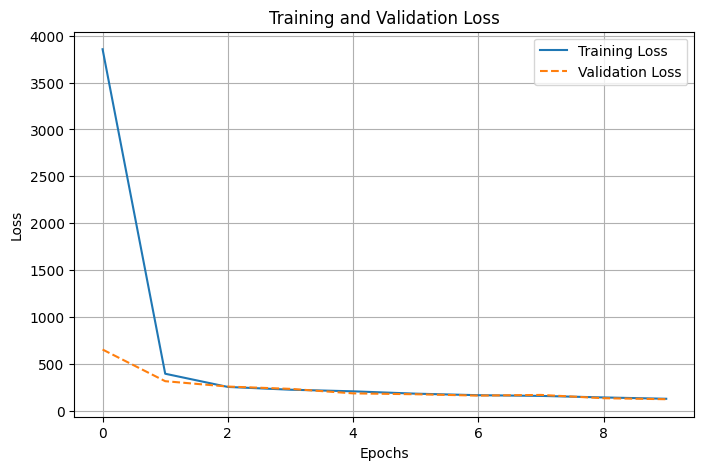

In [36]:
import matplotlib.pyplot as plt

# 取得 loss 和 validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# 繪製曲線
plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='dashed')

# 添加標籤和標題
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

# 顯示圖表
plt.show()

Why did we run the model only for 10 epochs, even though the validation loss seems to be decreasing? Well, while training this model for more epochs, we previously observed that it is possible to decrease the validation loss to a very small number. But in that case, our actual test loss is not that great. This is because our model is overfitting the validation dataset. So to get a good test performance, we should stop our training at an intermediate value of the validation loss. We chose 10 epochs as that gives a good enough test error.



### How many engines are there?

Number of unique values in first column gives us the total number of engines that are under study in this dataset.

In [37]:
processed_test_data.shape

(497, 30, 14)

In [38]:
rul_pred = model.predict(processed_test_data).reshape(-1)
rul_pred , rul_pred.shape

16/16 [==============================] - 1s 3ms/step


(array([133.81624  , 132.95227  , 126.8663   , 127.67031  , 131.4319   ,
        132.07999  , 132.95299  ,  67.576385 ,  60.656998 ,  54.262093 ,
         47.568157 ,  46.006313 , 122.69615  , 114.90122  , 116.916245 ,
        113.63114  ,  97.86934  , 123.08686  , 126.09278  , 124.9172   ,
        126.627716 , 128.6062   , 116.49551  ,  98.747375 ,  97.667305 ,
        101.11948  , 107.44018  , 115.96494  , 121.472176 , 121.07048  ,
        118.2408   , 112.61594  , 126.449005 , 125.49696  , 129.75041  ,
        129.91383  , 119.977486 , 122.7268   , 124.88089  , 122.270996 ,
        125.56458  , 126.868286 ,  99.61134  ,  87.30382  ,  95.10854  ,
         94.23168  ,  86.96972  , 122.33873  , 111.78822  , 107.17002  ,
        105.36584  , 102.46599  , 105.24646  , 100.88064  ,  94.21333  ,
         89.94544  ,  79.955215 ,  85.73759  ,  81.10274  ,  90.662506 ,
         77.217766 ,  64.96679  , 133.33492  , 133.48038  , 131.3188   ,
        126.933014 , 124.63969  , 105.552155 , 103.

In [39]:
np.cumsum(num_test_windows_list)[:-1]

array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127,
       132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192,
       197, 202, 207, 212, 217, 222, 227, 232, 237, 242, 247, 252, 257,
       262, 267, 272, 277, 282, 287, 292, 297, 302, 307, 312, 317, 322,
       327, 332, 337, 342, 347, 352, 357, 362, 367, 372, 377, 382, 387,
       392, 397, 402, 407, 412, 417, 422, 427, 432, 437, 442, 447, 452,
       457, 462, 467, 472, 477, 482, 487, 492])

In [40]:
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
preds_for_each_engine

[array([133.81624, 132.95227], dtype=float32),
 array([126.8663 , 127.67031, 131.4319 , 132.07999, 132.95299],
       dtype=float32),
 array([67.576385, 60.656998, 54.262093, 47.568157, 46.006313],
       dtype=float32),
 array([122.69615 , 114.90122 , 116.916245, 113.63114 ,  97.86934 ],
       dtype=float32),
 array([123.08686 , 126.09278 , 124.9172  , 126.627716, 128.6062  ],
       dtype=float32),
 array([116.49551 ,  98.747375,  97.667305, 101.11948 , 107.44018 ],
       dtype=float32),
 array([115.96494 , 121.472176, 121.07048 , 118.2408  , 112.61594 ],
       dtype=float32),
 array([126.449005, 125.49696 , 129.75041 , 129.91383 , 119.977486],
       dtype=float32),
 array([122.7268  , 124.88089 , 122.270996, 125.56458 , 126.868286],
       dtype=float32),
 array([99.61134, 87.30382, 95.10854, 94.23168, 86.96972], dtype=float32),
 array([122.33873, 111.78822, 107.17002, 105.36584, 102.46599],
       dtype=float32),
 array([105.24646 , 100.88064 ,  94.21333 ,  89.94544 ,  79.95521

In [41]:
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
mean_pred_for_each_engine

[133.3842544555664,
 130.2002975463867,
 55.21398925781251,
 113.20281982421875,
 125.86615142822266,
 104.29396820068361,
 117.87286682128908,
 126.31753997802736,
 124.46231079101562,
 92.64502105712891,
 109.82575988769533,
 94.04821777343751,
 79.9374771118164,
 129.9413589477539,
 107.75513305664063,
 90.82659759521485,
 51.196858978271486,
 31.95278396606446,
 102.01789550781251,
 25.130485916137694,
 82.10967712402345,
 125.58140258789064,
 131.65918579101563,
 19.73936309814453,
 123.24014587402345,
 125.63161315917968,
 80.38621826171875,
 107.49151916503907,
 72.78399658203125,
 128.74933624267578,
 13.127077484130862,
 49.95315475463868,
 129.50570068359377,
 9.6156813621521,
 19.441192626953125,
 29.62539978027344,
 32.57052307128906,
 62.1787956237793,
 125.81715850830079,
 34.8969467163086,
 27.188336181640622,
 16.163918113708498,
 70.30796356201172,
 117.67553100585938,
 100.0614227294922,
 38.82193298339844,
 113.85590209960938,
 104.92862091064454,
 20.37355537414551,

In [42]:
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  17.912231640281966


## Save the model

In [43]:
tf.keras.models.save_model(model, "FD001_LSTM_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

We will now compute the RMSE by taking only last example of each engine.

In [44]:
num_test_windows_list[:5], np.unique(num_test_windows_list)

([2, 5, 5, 5, 5], array([2, 5]))

In [45]:
np.cumsum(num_test_windows_list) - 1

array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126,
       131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191,
       196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256,
       261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321,
       326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386,
       391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451,
       456, 461, 466, 471, 476, 481, 486, 491, 496])

In [46]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  17.188959487269106


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where, 

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [47]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [48]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  778.6153848873541


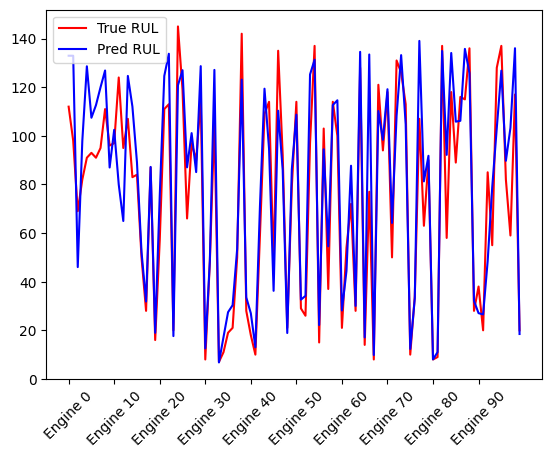

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")

# 設定 x 軸標籤
num_engines = 100  # 假設有 100 個引擎
x_labels = [f"Engine {i}" for i in range(0, num_engines, 10)]  # 每 10 個引擎顯示一次

# 設定刻度顯示位置
x_ticks = np.arange(0, num_engines, 10)  # 每 10 個顯示一次

# 更新 x 軸顯示
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)

# 顯示圖例
plt.legend()

# 顯示圖形
plt.show()

In [50]:
# 獲取 true_rul 排序後的索引
sorted_indices = np.argsort(true_rul)
# 根據索引重新排序 true_rul 和 preds_for_last_example
sorted_true_rul = true_rul[sorted_indices]
sorted_preds_for_last_example = preds_for_last_example[sorted_indices]

In [51]:
sorted_true_rul[:5]

array([7, 8, 8, 8, 9])

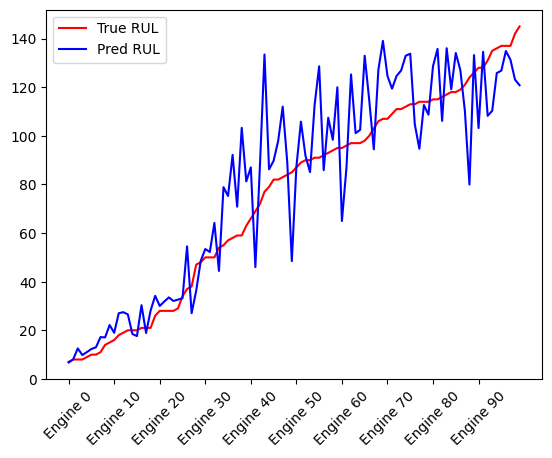

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# 假設 sorted_true_rul 和 sorted_preds_for_last_example 已經定義

# 繪製 true 和 predicted RUL
plt.plot(sorted_true_rul, label="True RUL", color="red")
plt.plot(sorted_preds_for_last_example, label="Pred RUL", color="blue")

# 設定 x 軸標籤
num_engines = 100  # 假設有 100 個引擎
x_labels = [f"Engine {i}" for i in range(0, num_engines, 10)]  # 每 10 個引擎顯示一次

# 設定刻度顯示位置
x_ticks = np.arange(0, num_engines, 10)  # 每 10 個顯示一次

# 更新 x 軸顯示
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)

# 顯示圖例
plt.legend()

# 顯示圖形
plt.show()

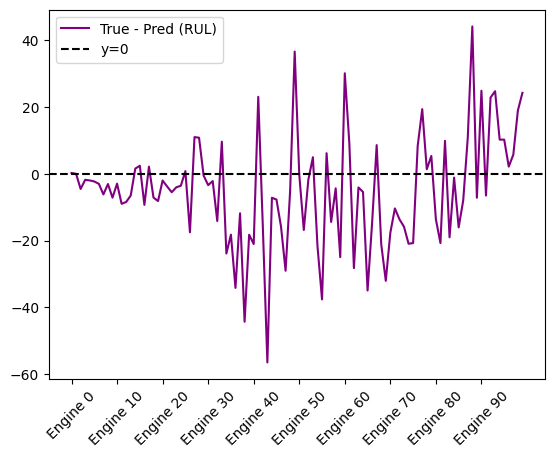

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# 計算絕對誤差
All_error = sorted_true_rul - sorted_preds_for_last_example

# 繪製絕對誤差
plt.plot(All_error, label="True - Pred (RUL)", color="purple")

# 繪製 y=0 虛線
plt.axhline(0, color='black', linestyle='--', label="y=0")

# 設定 x 軸標籤
num_engines = 100  # 假設有 100 個引擎
x_labels = [f"Engine {i}" for i in range(0, num_engines, 10)]  # 每 10 個引擎顯示一次

# 設定刻度顯示位置
x_ticks = np.arange(0, num_engines, 10)  # 每 10 個顯示一次

# 更新 x 軸顯示
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)

# 顯示圖例
plt.legend()

# 顯示圖形
plt.show()

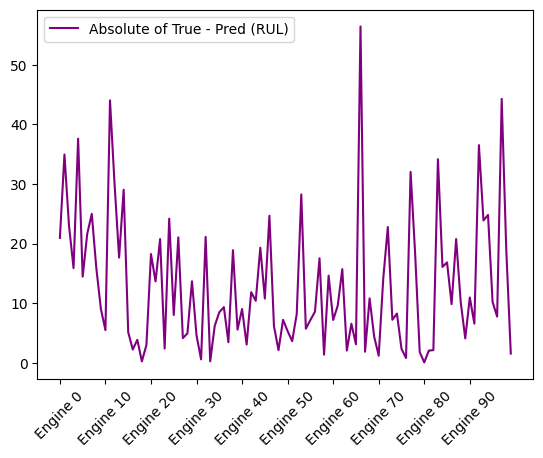

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# 計算絕對誤差
absolute_error = np.abs(true_rul - preds_for_last_example)

# 設定 x 軸標籤
num_engines = 100  # 假設有 100 個引擎
x_labels = [f"Engine {i}" for i in range(0, num_engines, 10)]  # 每 10 個引擎顯示一次

# 設定刻度顯示位置
x_ticks = np.arange(0, num_engines, 10)  # 每 10 個顯示一次

# 更新 x 軸顯示
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)

# 繪製絕對誤差
plt.plot(absolute_error, label="Absolute of True - Pred (RUL)", color="purple")
plt.legend()
plt.show()

In [55]:
absolute_error.shape

(100,)

In [56]:
absolute_error.mean()

13.007840237617494

It is very likely that readers may get sligtly different results while running this notebook on their system. This happens because of the nondeterministic nature of some deep learning operations and dependence of libraries like `Tensorflow` on computer architecture. Therefore, to make our results reproducible, we also share saved models of all our notebooks. All saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/saved_models/cmapss). A notebook describing the procedure to use the saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_using_saved_model_deep_learning.ipynb). As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open). 

## 看看 Model 在整個過程中的 RUL 預測準不準

In [57]:
CMAPSSData_path = "../../../__datasets/CMAPSSData/"

In [ ]:
train_data = pd.read_csv(CMAPSSData_path+"/train_FD001.txt", sep= "\s+", header = None)
test_data = pd.read_csv(CMAPSSData_path+"/test_FD001.txt", sep = "\s+", header = None)

window_length = 30
shift = 1
early_rul = int(upper_bound)      
# early_rul = 125
# early_rul = None     

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

In [59]:
# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

In [60]:
train_data

0         1         2         3         4         5         6   \
0        1.0 -1.721725 -0.134255 -0.925936  1.121141 -0.516338 -0.862813   
1        1.0 -1.061780  0.211528 -0.643726  0.431930 -0.798093 -0.958818   
2        1.0 -0.661813 -0.413166 -0.525953  1.008155 -0.234584 -0.557139   
3        1.0 -0.661813 -1.261314 -0.784831  1.222827  0.188048 -0.713826   
4        1.0 -0.621816 -1.251528 -0.301518  0.714393 -0.516338 -0.457059   
...      ...       ...       ...       ...       ...       ...       ...   
20626  100.0  1.618000  1.216258  2.188375 -2.189329  1.315066  0.012547   
20627  100.0  1.717992  2.279706  2.738351 -2.833345  1.878576 -0.006020   
20628  100.0  1.478011  1.946971  2.138377 -2.742957  2.019453  0.029755   
20629  100.0  1.098043  2.403666  1.955051 -3.036719  2.160330  0.383884   
20630  100.0  2.337940  1.607712  2.578358 -2.912435  2.301208 -0.170405   

             7         8         9         10        11        12        13  \
0     -0.266467  0.334262 -1.058890 -0.269071 -0.603816 -0.781710  1.348493   
1     -0.191583  1.174899 -0.363646 -0.642845 -0.275852 -0.781710  1.016528   
2     -1.015303  1.364721 -0.919841 -0.551629 -0.649144 -2.073094  0.739891   
3     -1.539489  1.961302 -0.224597 -0.520176 -1.971665 -0.781710  0.352598   
4     -0.977861  1.052871 -0.780793 -0.521748 -0.339845 -0.136018  0.463253   
...         ...       ...       ...       ...       ...       ...       ...   
20626  1.980044 -2.607969  2.278282 -0.322542  1.425294  2.446751 -1.805173   
20627  1.867718 -2.350355  1.722087 -0.380207  1.913240  1.155367 -2.856395   
20628  2.054927 -1.902919  2.000184 -0.141684  3.265092  3.092444 -2.081810   
20629  3.178182 -2.363913  1.861136 -0.233948  2.579834  1.155367 -2.911722   
20630  2.466787 -2.865584  2.278282 -0.336696  1.638604  1.801059 -2.469103   

             14  
0      1.194427  
1      1.236922  
2      0.503423  
3      0.777792  
4      1.059552  
...         ...  
20626 -2.921113  
20627 -1.203764  
20628 -3.292481  
20629 -2.085072  
20630 -2.194080  

[20631 rows x 15 columns]

In [61]:
test_data

0         1         2         3         4         5         6   \
0        1.0  0.678077 -0.853550 -1.191480  0.601408 -0.798093 -0.682579   
1        1.0 -1.941707 -0.338137 -1.501467  1.674769 -1.220725 -0.490117   
2        1.0 -0.441831 -0.584426 -0.843717  0.838677 -0.657216 -0.375093   
3        1.0 -0.481827 -1.044384 -0.279297  0.793483 -0.938970 -0.903570   
4        1.0 -0.341839 -0.543650 -0.779276  0.895170 -1.220725 -0.937081   
...      ...       ...       ...       ...       ...       ...       ...   
13091  100.0  1.118041  1.456023  0.761769  0.047780 -1.079848  3.492703   
13092  100.0  1.078044  0.842747  1.457295 -0.166892 -0.657216  3.416171   
13093  100.0  1.518008  0.428459 -0.234855 -0.370266  0.188048  3.693768   
13094  100.0  1.158038  0.728573  1.158419  0.002586 -0.375461  3.786150   
13095  100.0  0.538089  1.809962  1.783948 -1.002983 -0.516338  4.066011   

             7         8         9         10        11        12        13  \
0     -1.277396  0.415614 -0.919841 -0.954235 -0.985107 -0.781710  0.241943   
1     -0.154141  1.012195 -0.502695 -0.216648 -1.649034 -0.136018  1.127183   
2     -0.154141  0.754581 -0.919841 -0.715712  0.052112 -0.136018  1.459148   
3     -0.977861 -0.045381 -0.641744 -0.568929 -1.345067 -1.427402  1.016528   
4     -0.865536  0.998637 -0.919841 -0.745069 -1.041101 -2.073094  0.961200   
...         ...       ...       ...       ...       ...       ...       ...   
13091  0.557254 -0.980929 -1.336988  3.644806  0.782698  0.509675 -0.919933   
13092  0.220277 -0.492817 -0.085548  3.517419  0.241425  1.155367 -1.362553   
13093  0.107952 -0.316554 -0.780793  3.852400  0.393408  1.155367 -1.085916   
13094  0.257719 -0.113174 -0.224597  4.022249  0.772033  1.155367 -0.864606   
13095  0.969114 -0.465700 -0.641744  3.716101  1.283976  1.801059 -0.643296   

             14  
0      0.774097  
1      0.941305  
2      1.172256  
3      0.775945  
4      1.138999  
...         ...  
13091 -0.852719  
13092 -0.116449  
13093 -0.781586  
13094 -0.182962  
13095 -0.962652  

[13096 rows x 15 columns]

In [62]:
num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

In [63]:
# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.
processed_train_data = []
processed_train_targets = []

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

In [64]:
len(processed_train_data), len(processed_train_targets)

(100, 100)

In [65]:
for i in range(5):
    print(processed_train_data[i].shape)

(163, 30, 14)
(258, 30, 14)
(150, 30, 14)
(160, 30, 14)
(240, 30, 14)


In [66]:
for i in range(5):
    print(processed_train_targets[i].shape)

(163,)
(258,)
(150,)
(160,)
(240,)


In [67]:
processed_train_targets[0]

array([139., 139., 139., 139., 139., 139., 139., 139., 139., 139., 139.,
       139., 139., 139., 139., 139., 139., 139., 139., 139., 139., 139.,
       139., 139., 138., 137., 136., 135., 134., 133., 132., 131., 130.,
       129., 128., 127., 126., 125., 124., 123., 122., 121., 120., 119.,
       118., 117., 116., 115., 114., 113., 112., 111., 110., 109., 108.,
       107., 106., 105., 104., 103., 102., 101., 100.,  99.,  98.,  97.,
        96.,  95.,  94.,  93.,  92.,  91.,  90.,  89.,  88.,  87.,  86.,
        85.,  84.,  83.,  82.,  81.,  80.,  79.,  78.,  77.,  76.,  75.,
        74.,  73.,  72.,  71.,  70.,  69.,  68.,  67.,  66.,  65.,  64.,
        63.,  62.,  61.,  60.,  59.,  58.,  57.,  56.,  55.,  54.,  53.,
        52.,  51.,  50.,  49.,  48.,  47.,  46.,  45.,  44.,  43.,  42.,
        41.,  40.,  39.,  38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,
        30.,  29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,
        19.,  18.,  17.,  16.,  15.,  14.,  13.,  1

In [68]:
for i in range(5):
    print(model(processed_train_data[i]).shape)

(163, 1)
(258, 1)
(150, 1)
(160, 1)
(240, 1)


In [69]:
model(processed_train_data[1])

<tf.Tensor: shape=(258, 1), dtype=float32, numpy=
array([[140.57635  ],
       [140.62323  ],
       [140.82729  ],
       [140.70175  ],
       [140.72     ],
       [140.64545  ],
       [140.58553  ],
       [140.5383   ],
       [140.28073  ],
       [140.22505  ],
       [140.00607  ],
       [139.50885  ],
       [139.95486  ],
       [140.18634  ],
       [139.9379   ],
       [139.7826   ],
       [139.87376  ],
       [139.95178  ],
       [140.13243  ],
       [140.29509  ],
       [140.20522  ],
       [140.22513  ],
       [140.16034  ],
       [140.3011   ],
       [140.2307   ],
       [140.30774  ],
       [140.43376  ],
       [140.49335  ],
       [140.5466   ],
       [140.43903  ],
       [140.07886  ],
       [139.87343  ],
       [139.89752  ],
       [139.86357  ],
       [139.84358  ],
       [139.73917  ],
       [139.63416  ],
       [139.72014  ],
       [139.5131   ],
       [139.19757  ],
       [139.12721  ],
       [138.86148  ],
       [139.03299  ],
    

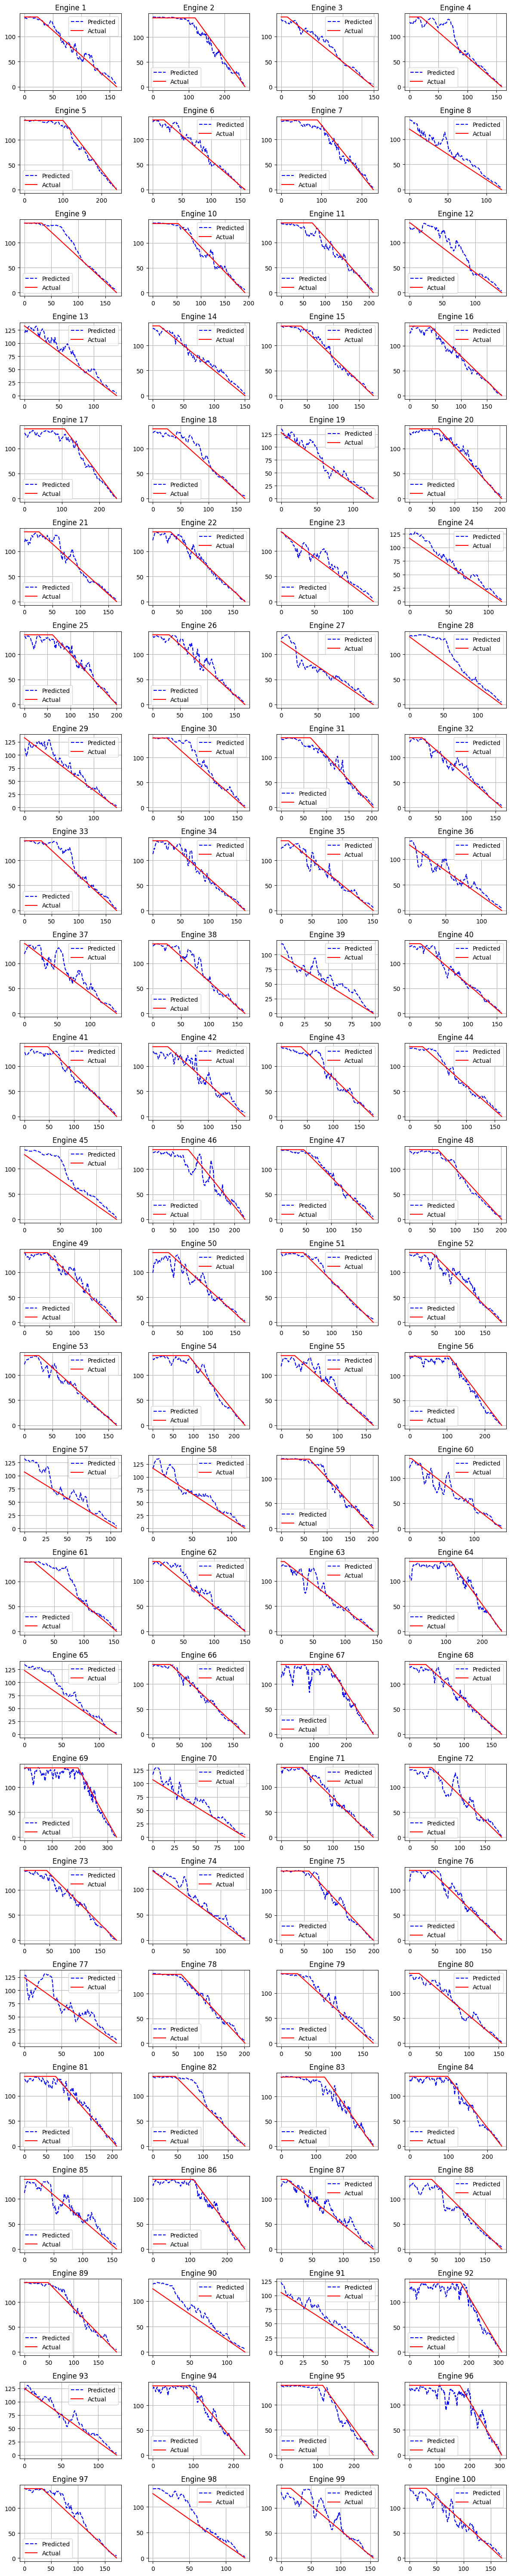

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# 假設 model_outputs[i] 和 processed_train_targets[i] 都是 y 值向量
# 長度一樣

# 產生範例數據（假設每個 y 向量有 100 個數值）
fig, axes = plt.subplots(25, 4, figsize=(12, 12*5))  # 3x3 子圖
axes = axes.flatten()  # 攤平成 1 維方便索引

for i in range(100):
    ax = axes[i]
    
    # x 軸用索引（因為 y 向量已經有對應的長度）
    x_indices = np.arange(processed_train_targets[i].shape[0])
    
    ax.plot(x_indices, model(processed_train_data[i]), label="Predicted", linestyle="--", color="blue")
    ax.plot(x_indices, processed_train_targets[i], label="Actual", linestyle="-", color="red")
    
    ax.set_title(f"Engine {i+1}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [71]:
# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

In [73]:
len(processed_test_data), len(num_test_windows_list)

(100, 100)

In [89]:
true_rul = pd.read_csv(CMAPSSData_path+"/RUL_FD001.txt", sep = '\s+', header = None)
true_rul

0
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]

In [114]:
true_rul.values[1]

array([98])

In [170]:
true_rul.values.shape

(100, 1)

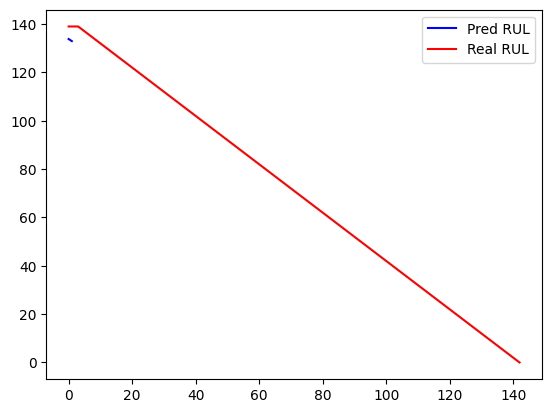

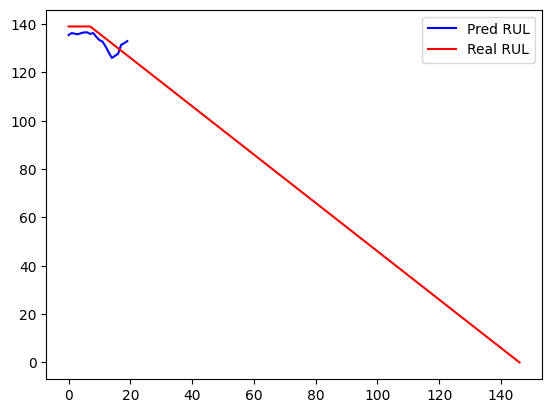

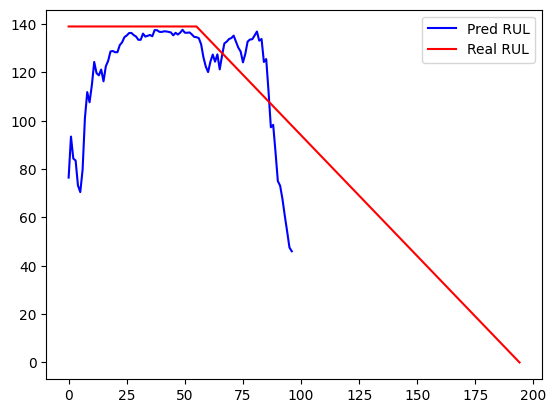

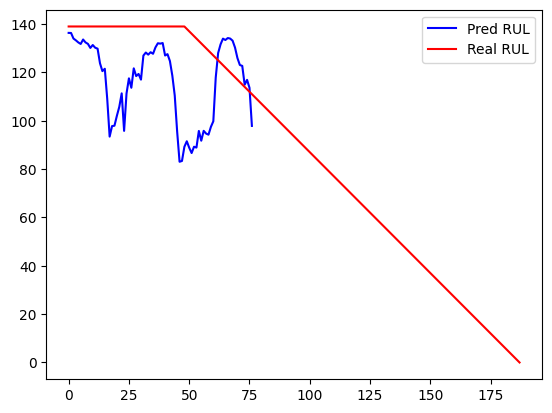

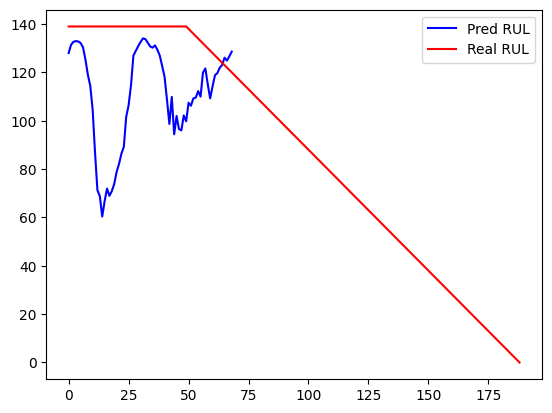

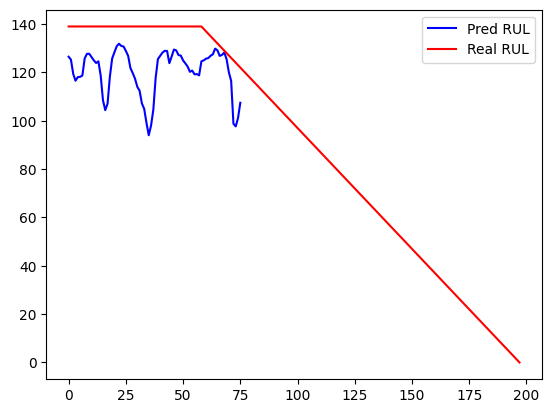

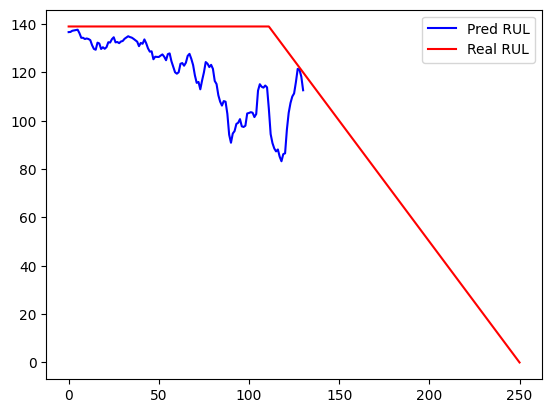

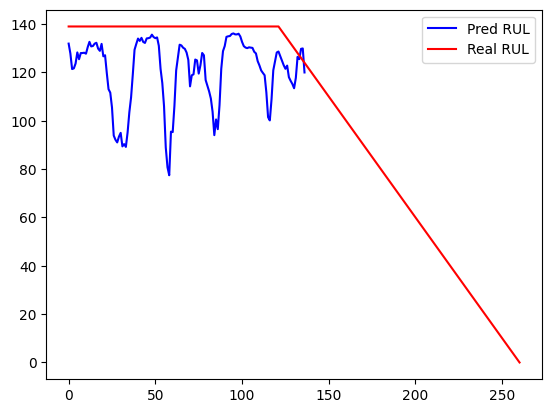

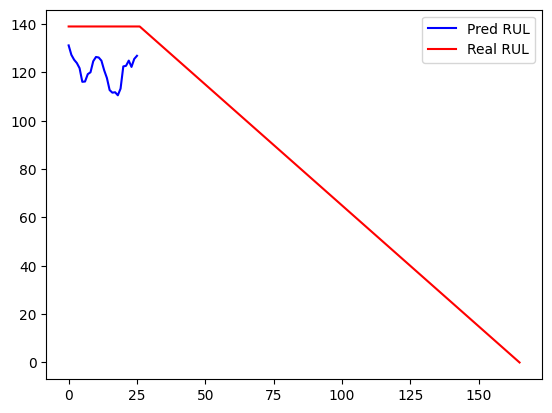

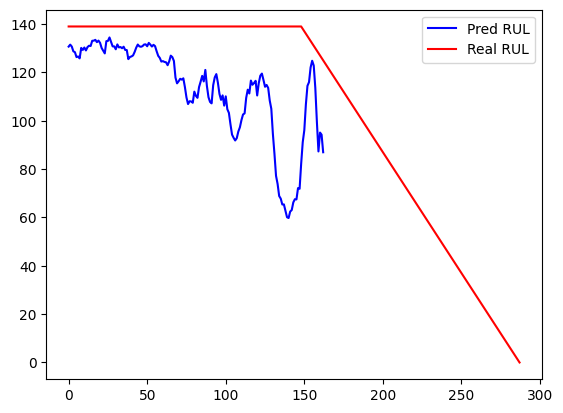

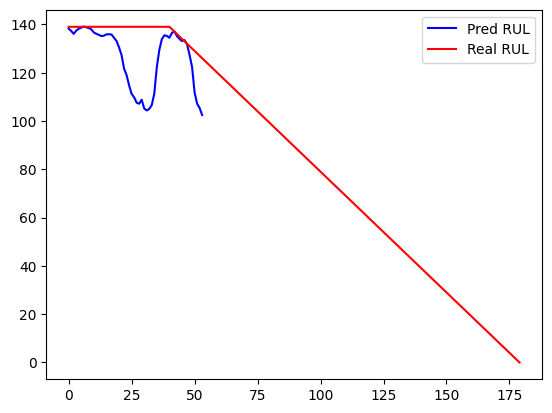

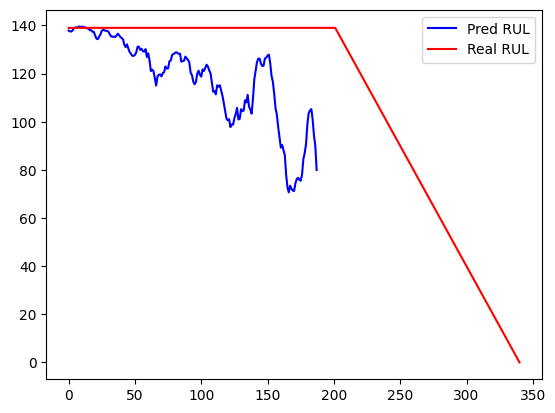

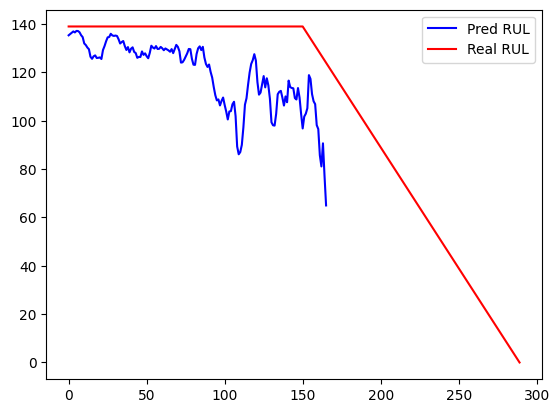

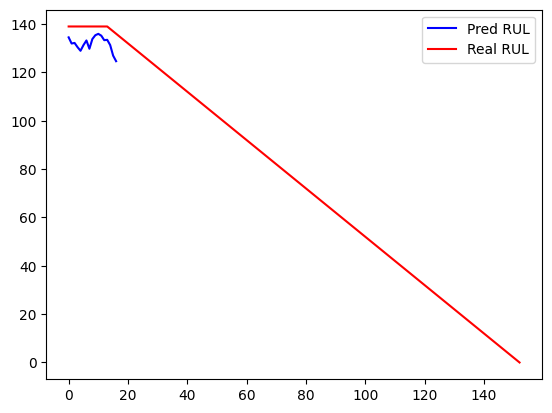

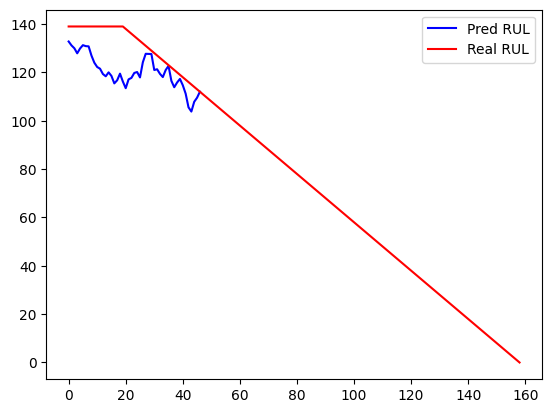

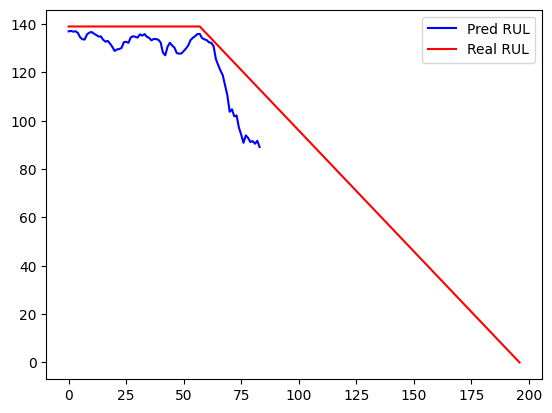

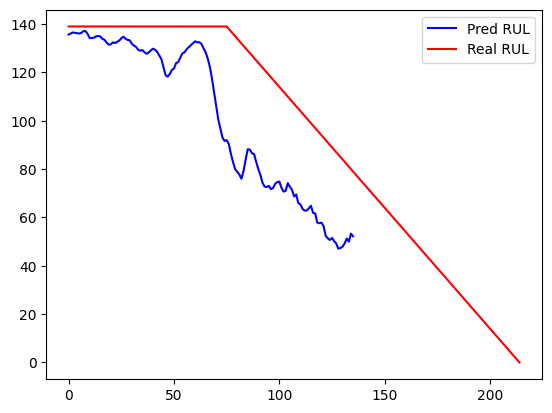

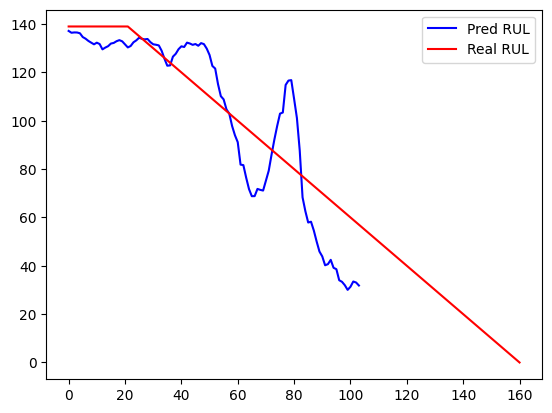

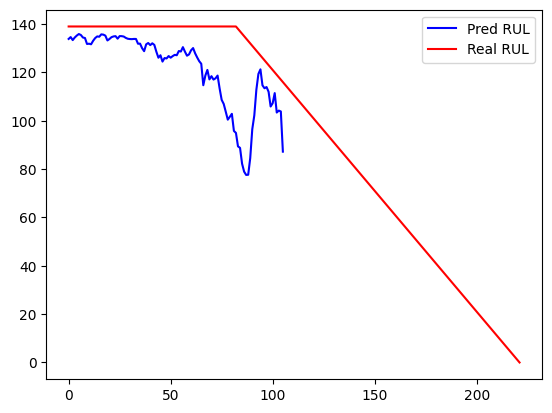

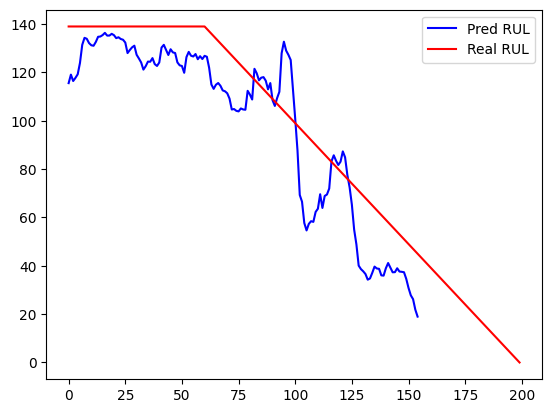

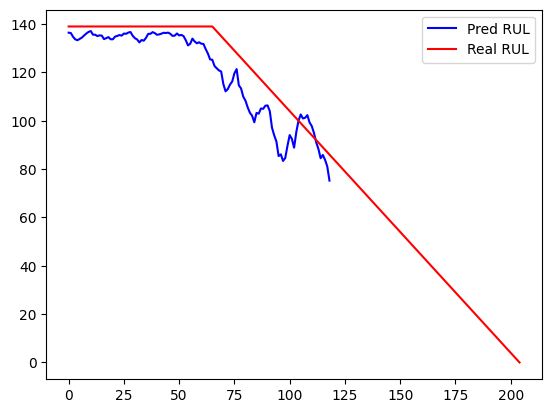

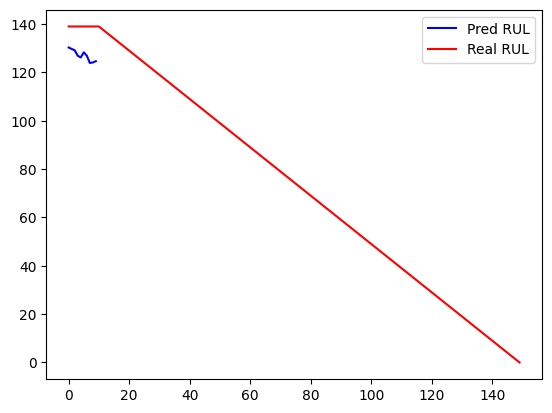

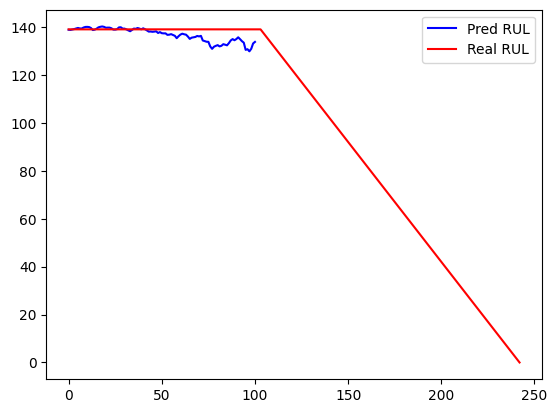

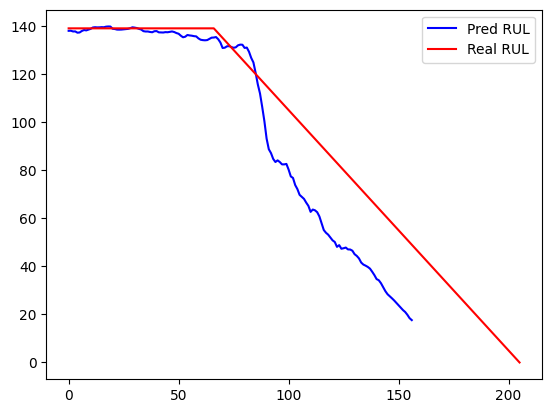

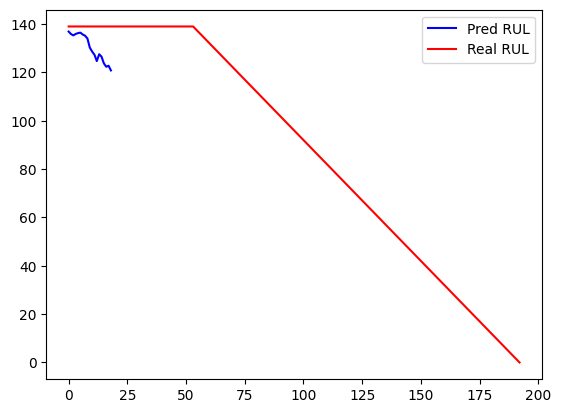

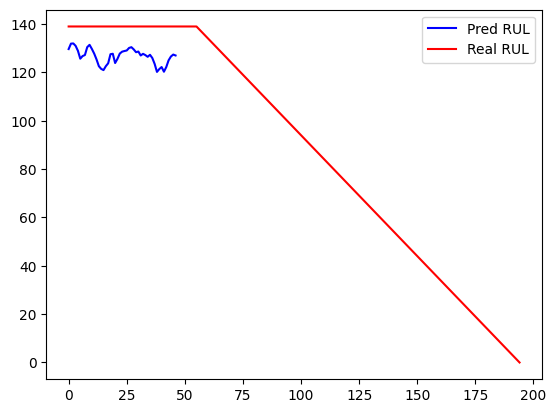

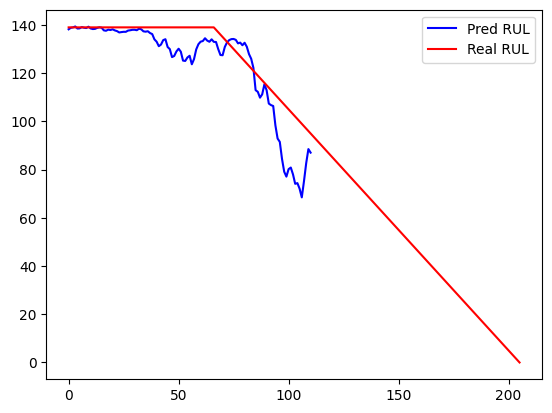

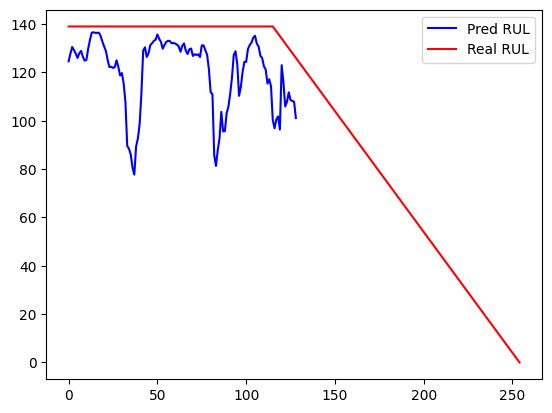

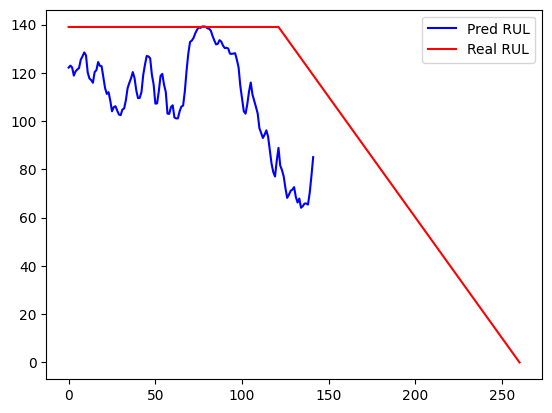

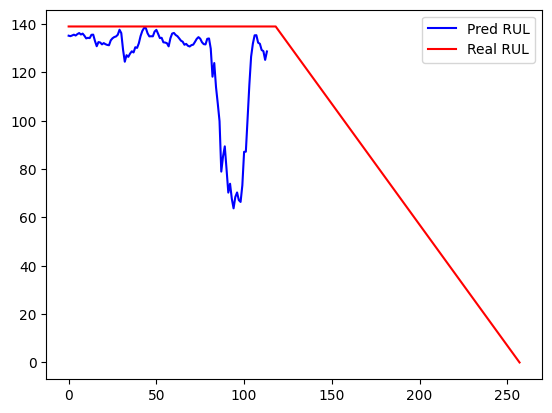

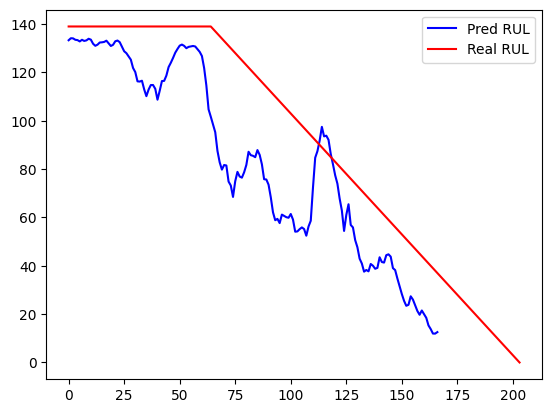

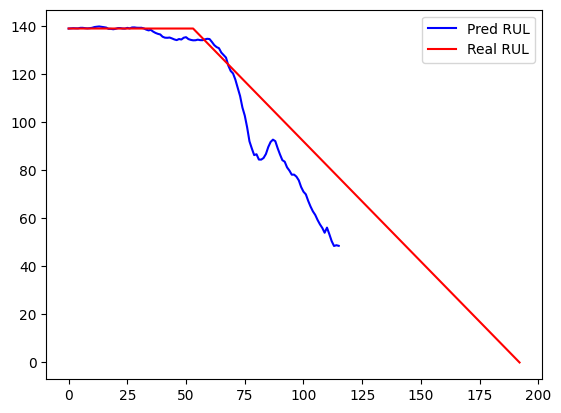

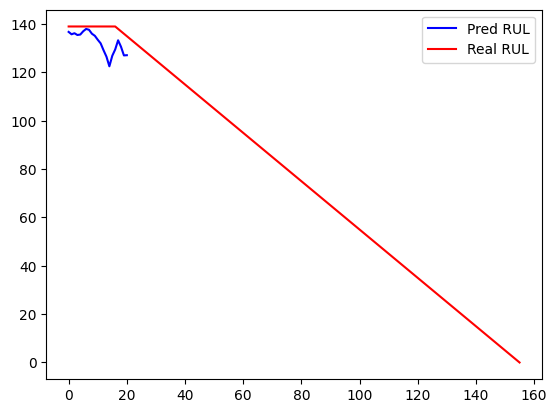

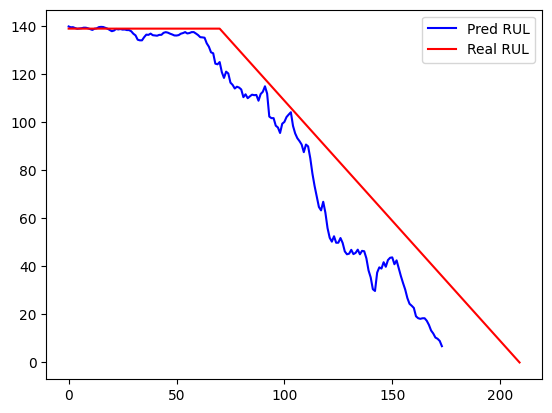

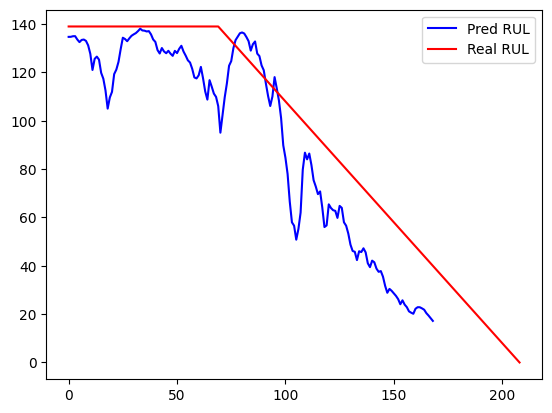

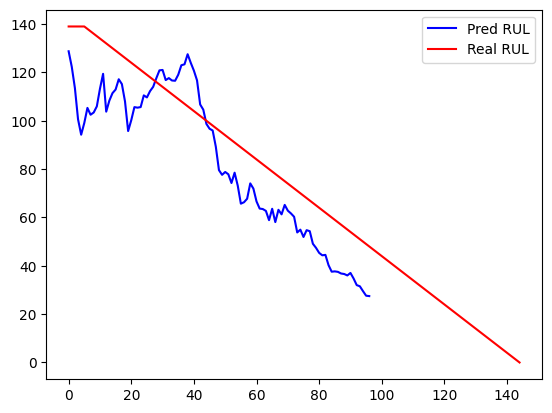

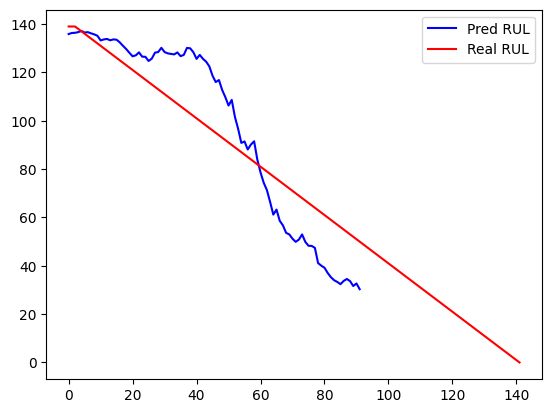

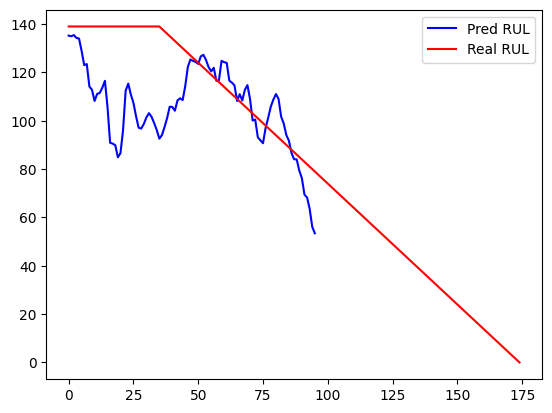

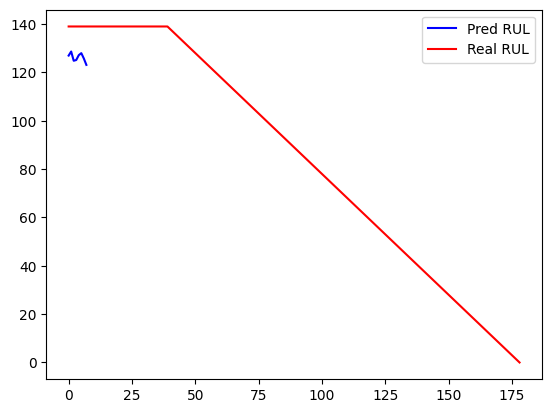

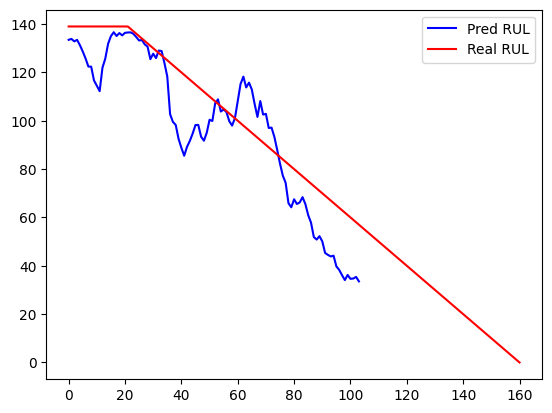

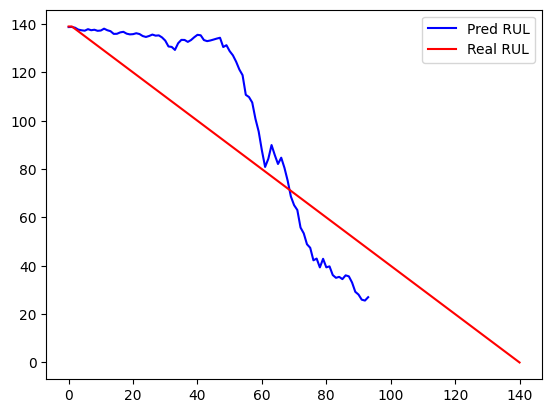

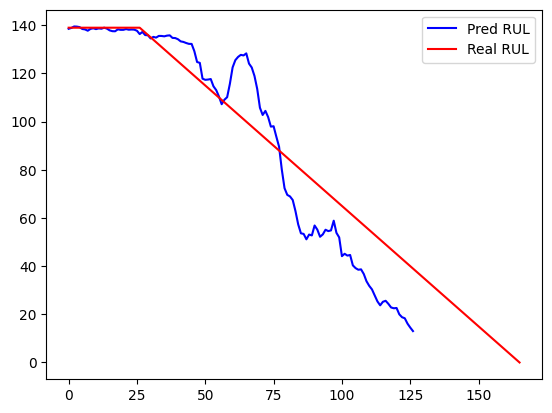

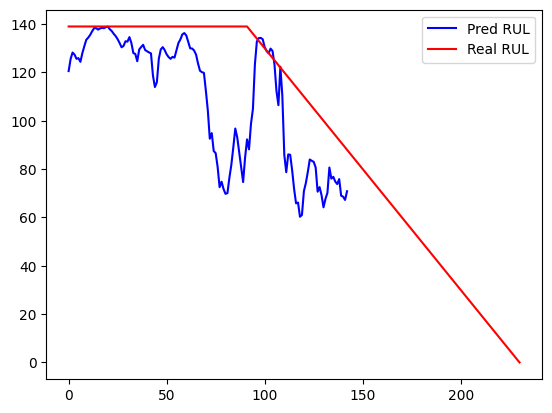

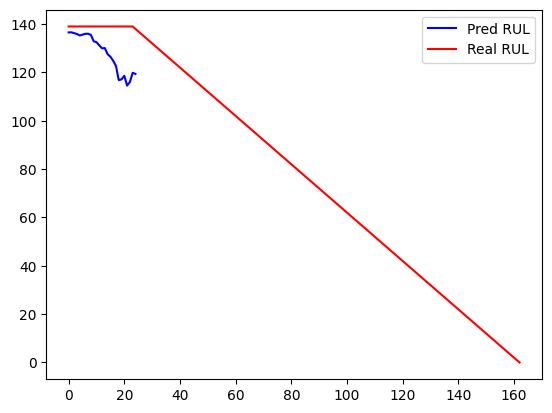

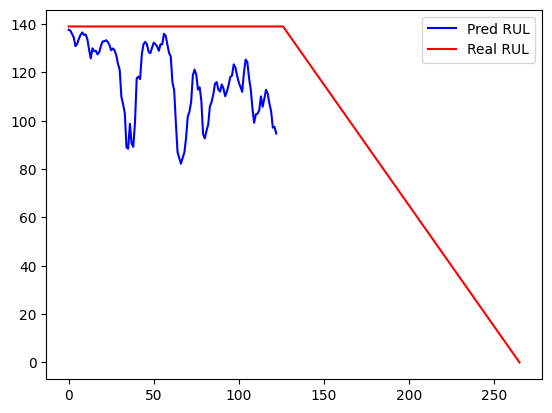

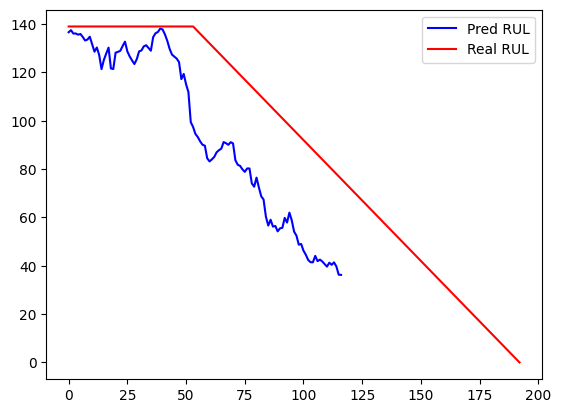

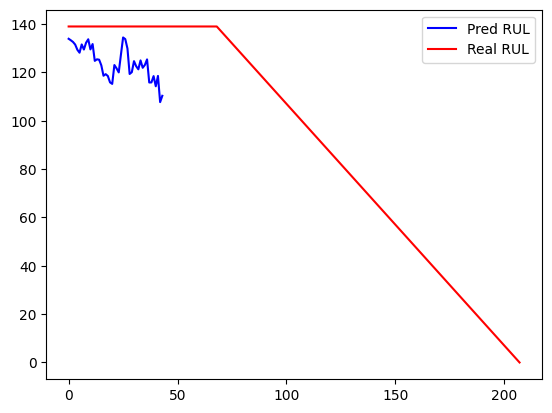

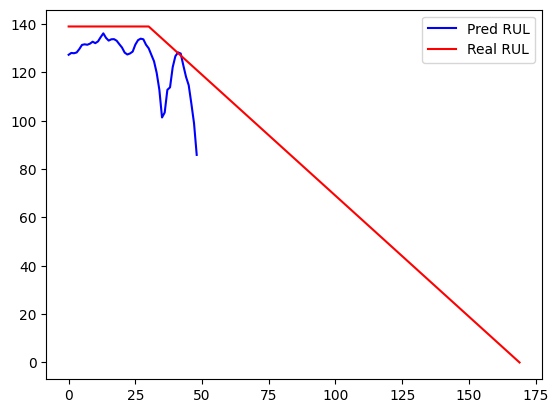

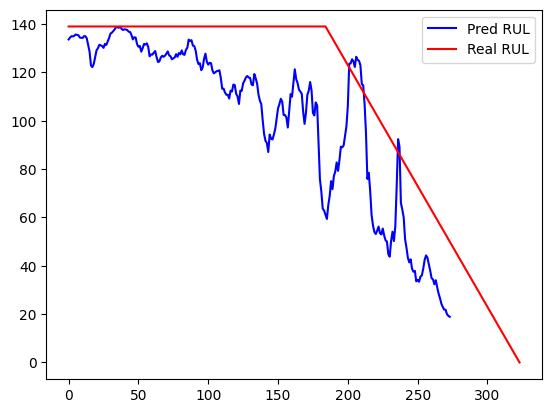

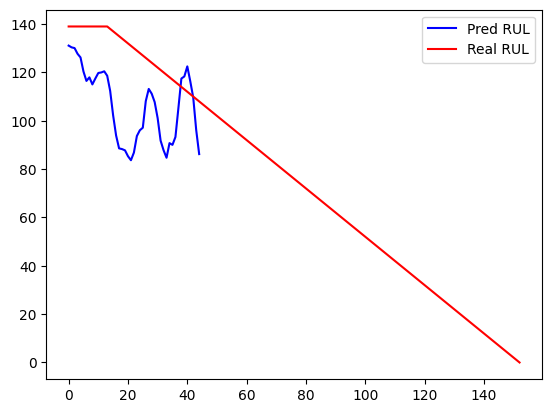

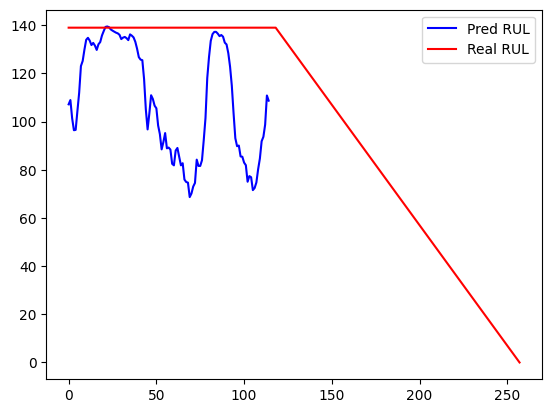

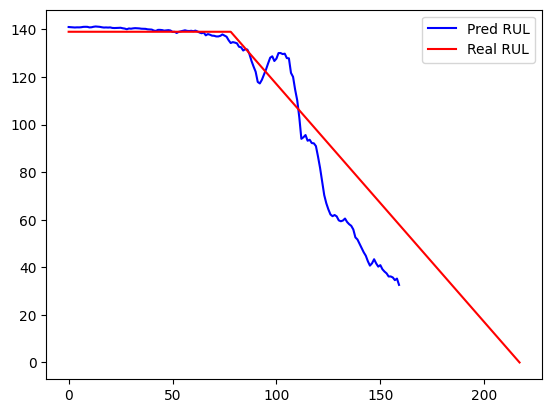

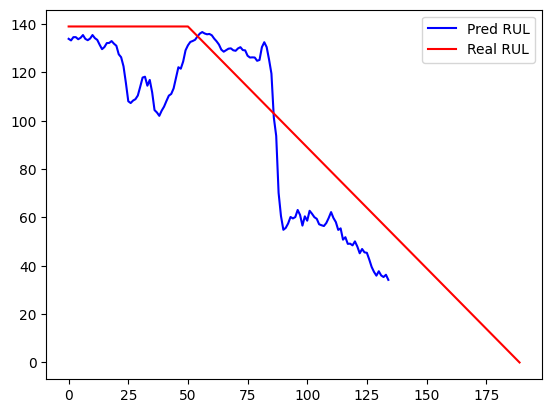

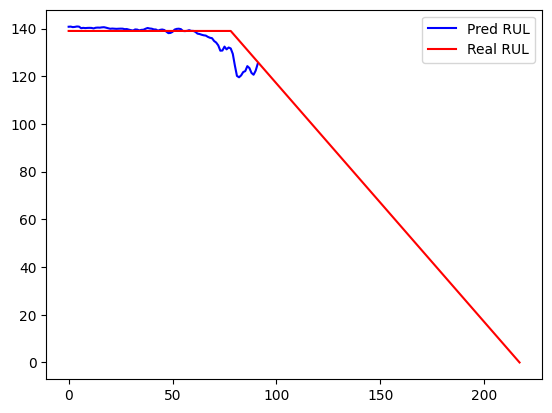

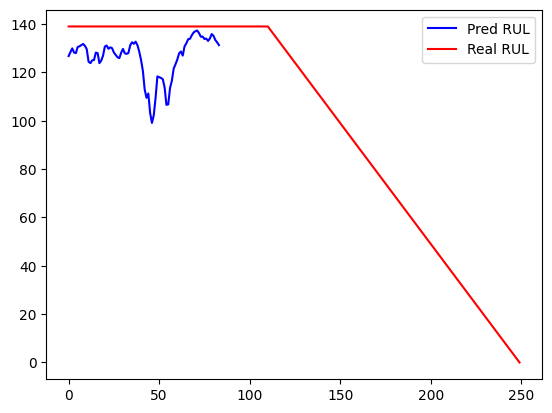

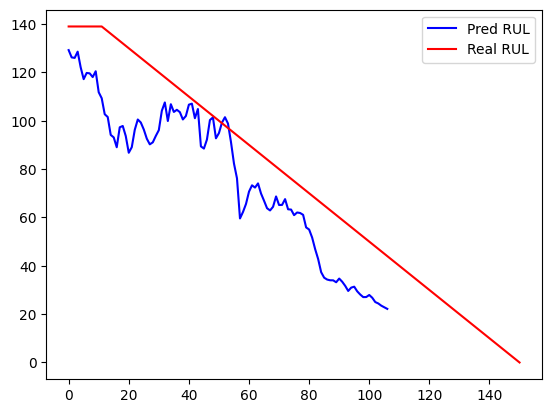

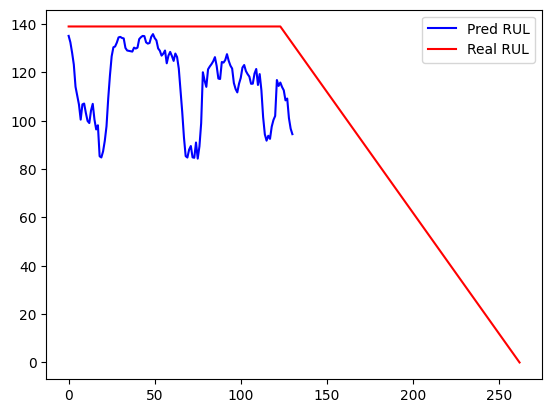

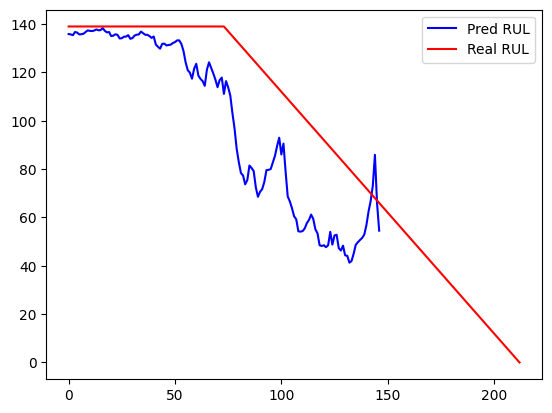

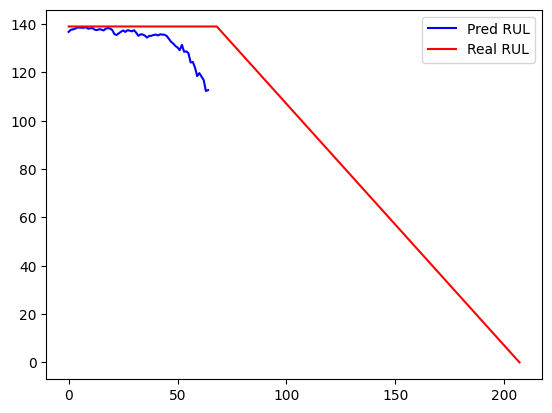

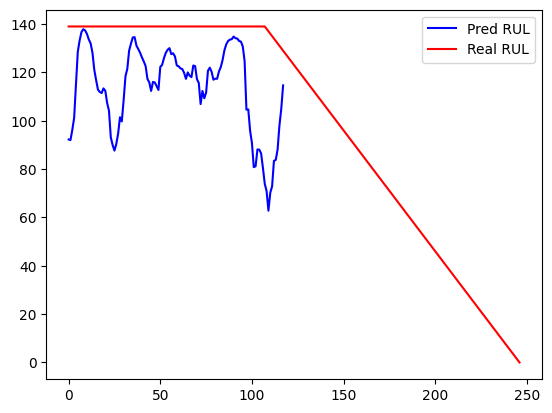

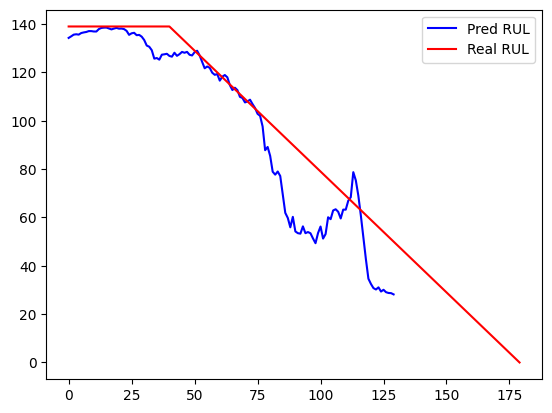

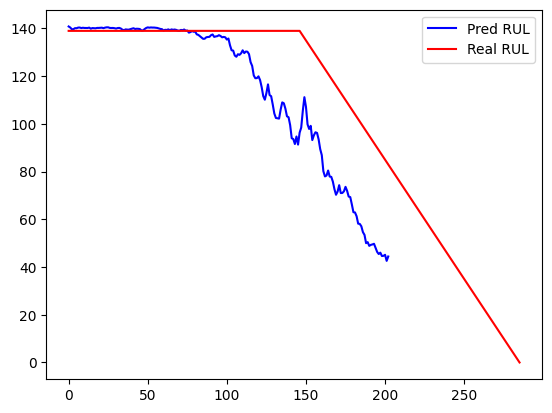

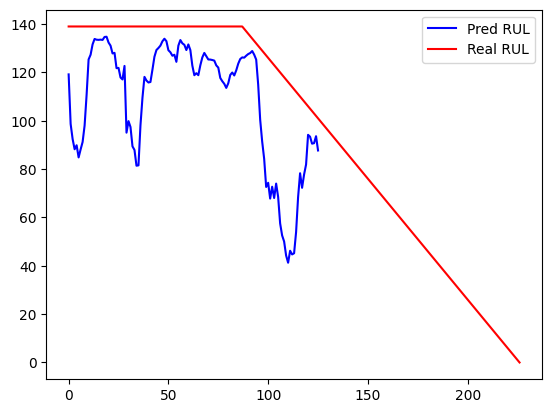

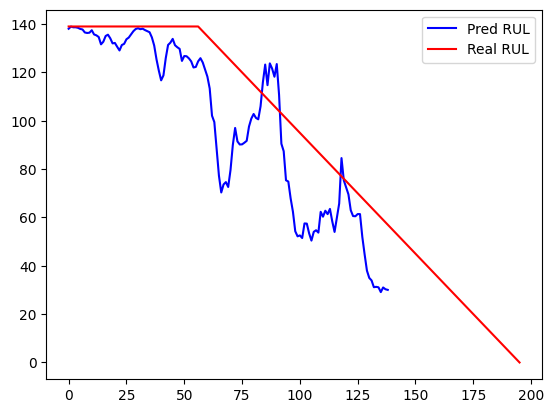

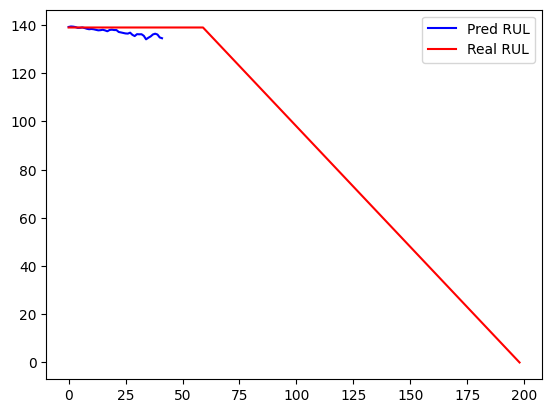

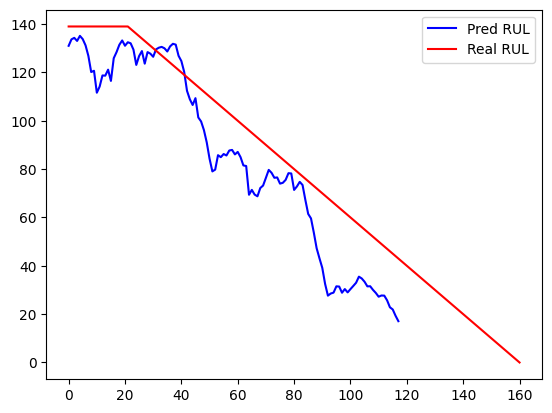

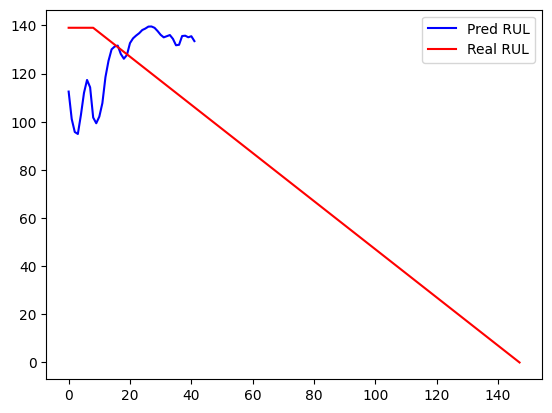

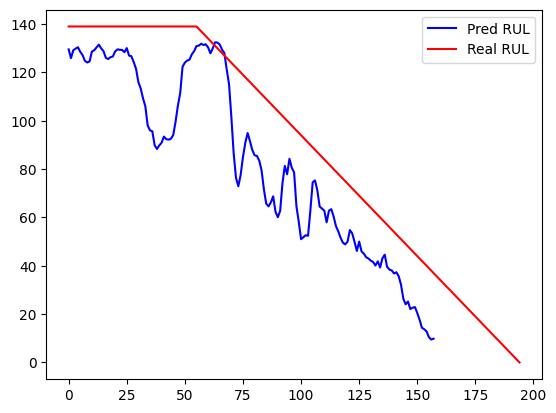

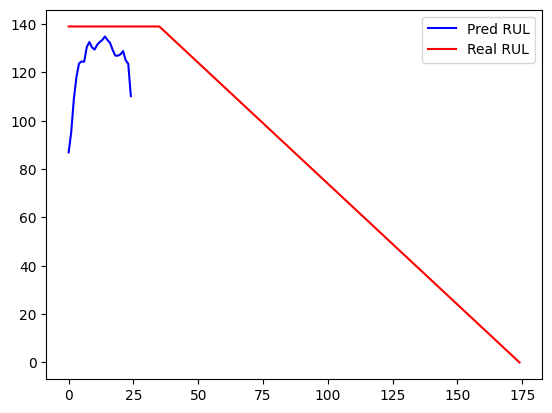

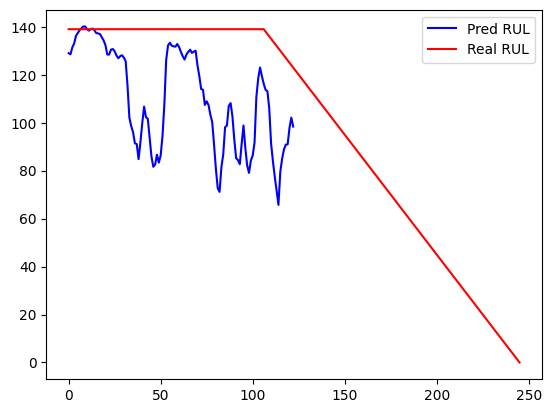

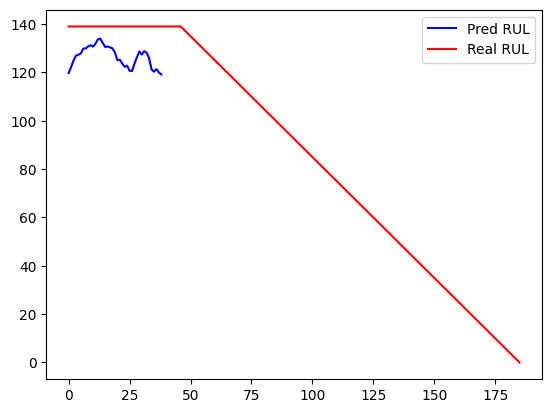

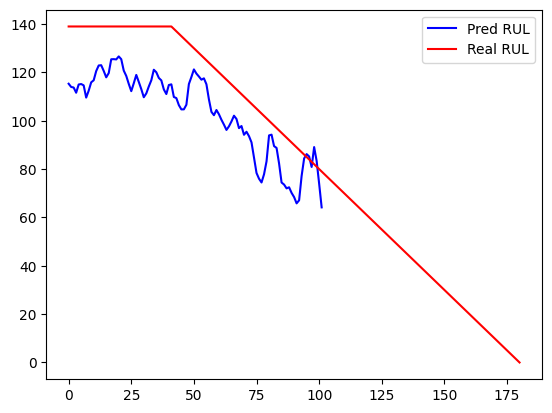

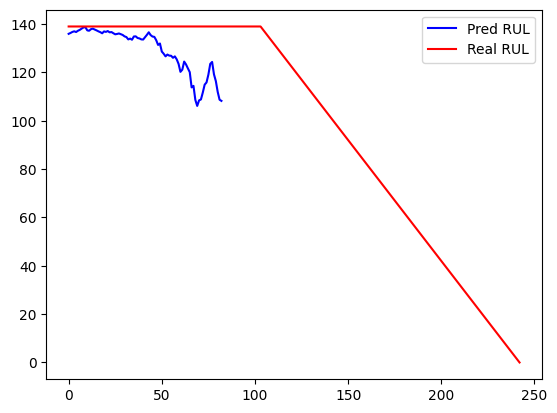

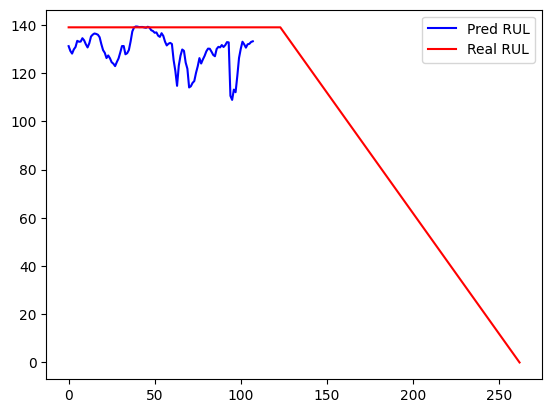

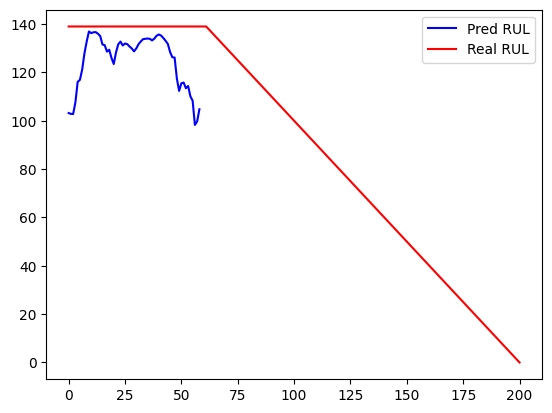

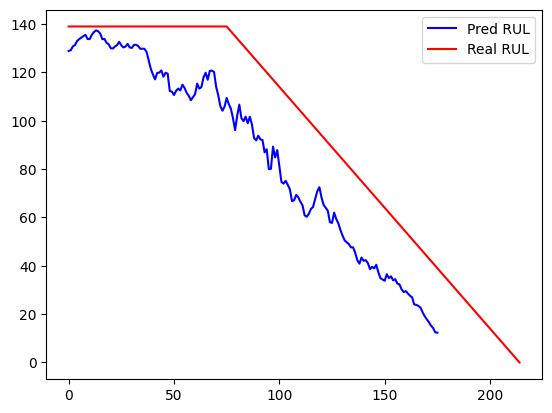

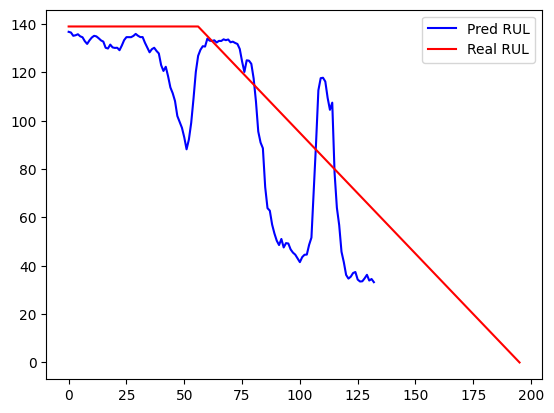

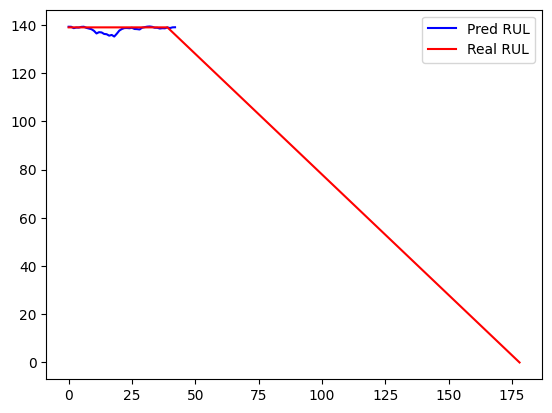

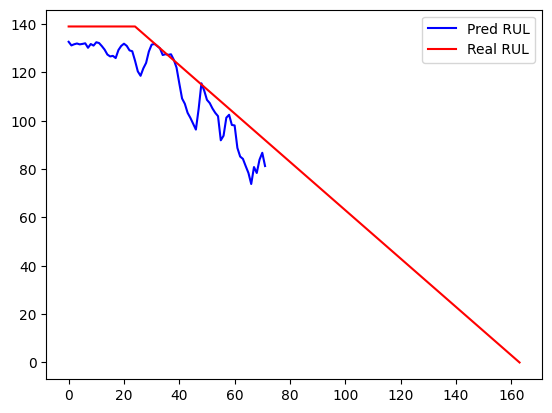

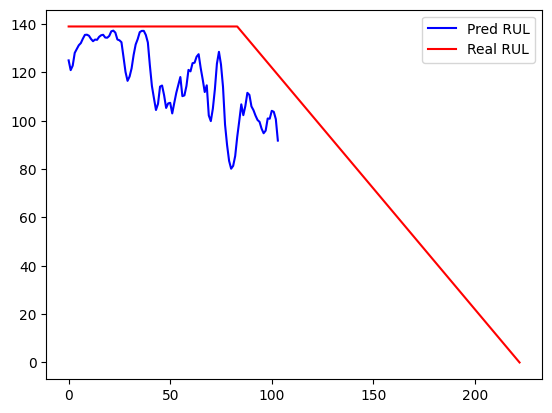

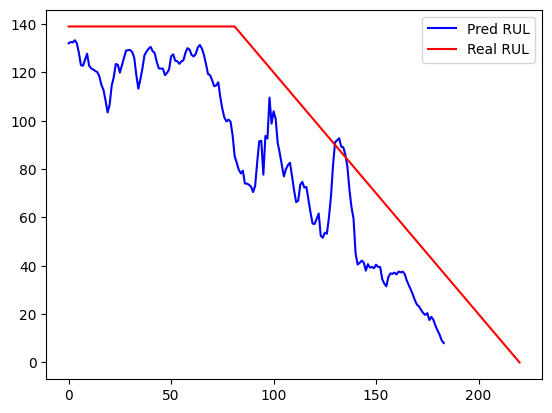

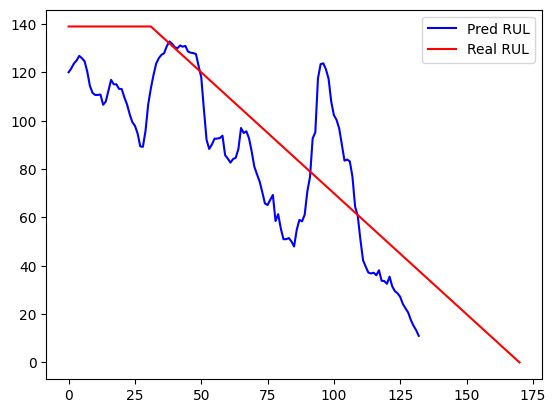

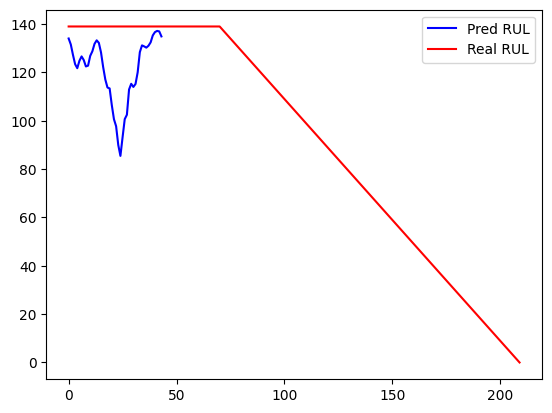

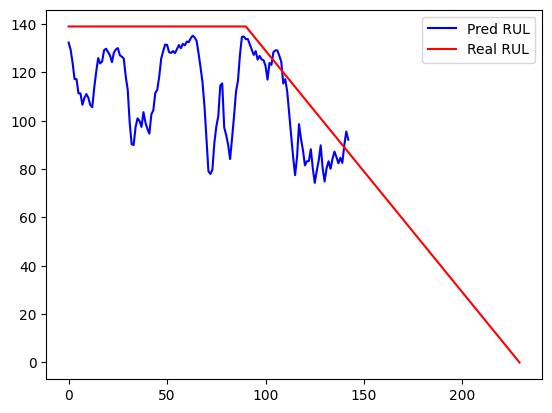

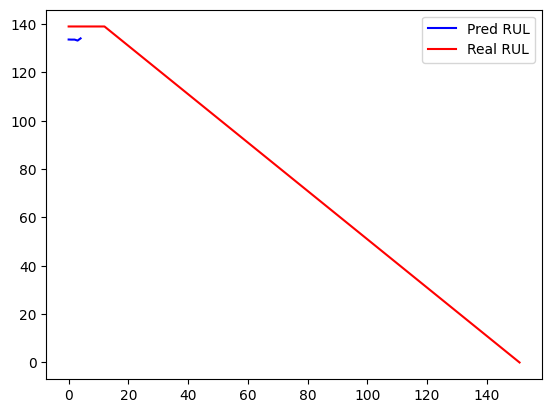

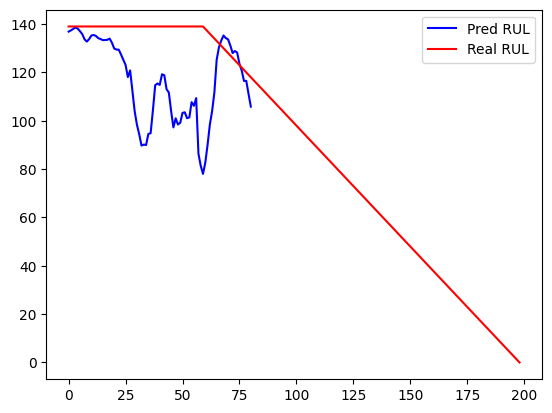

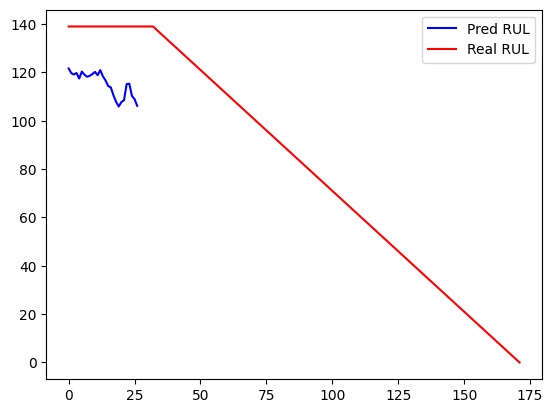

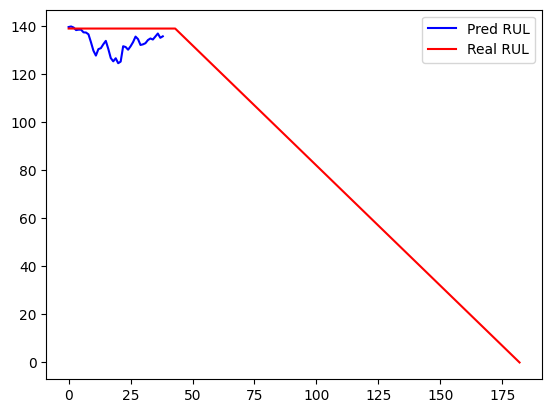

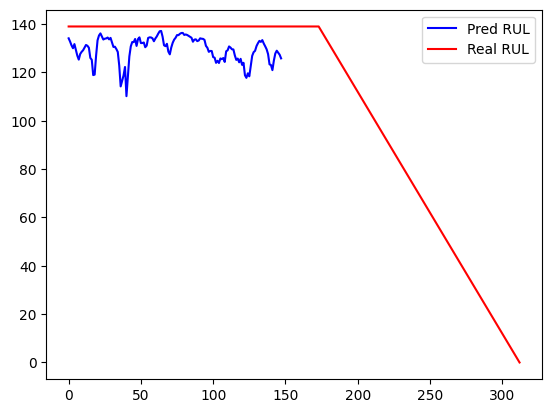

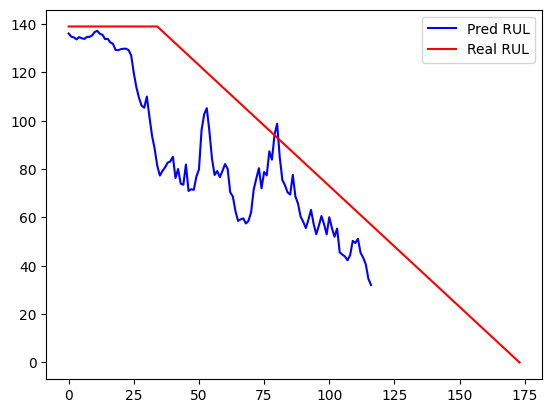

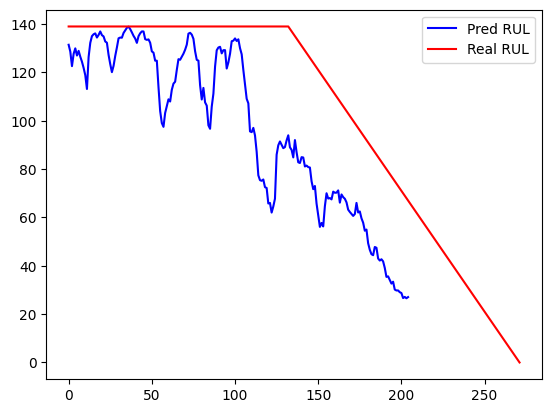

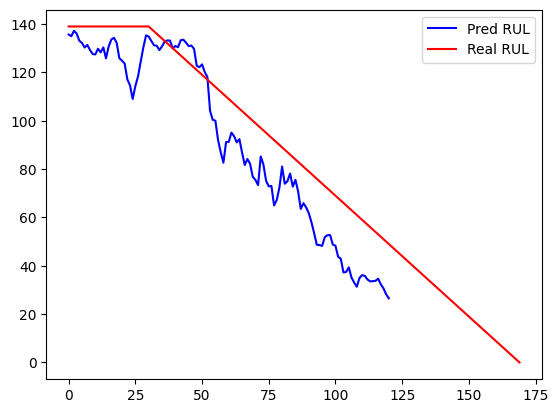

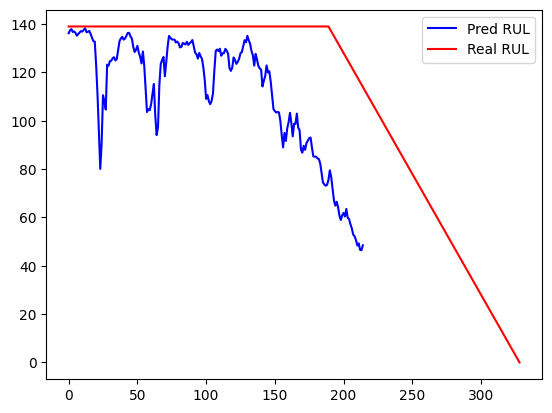

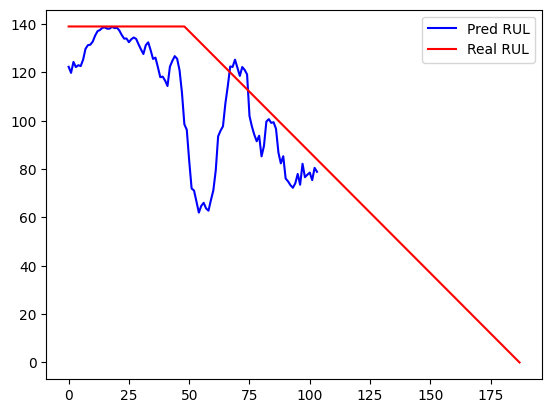

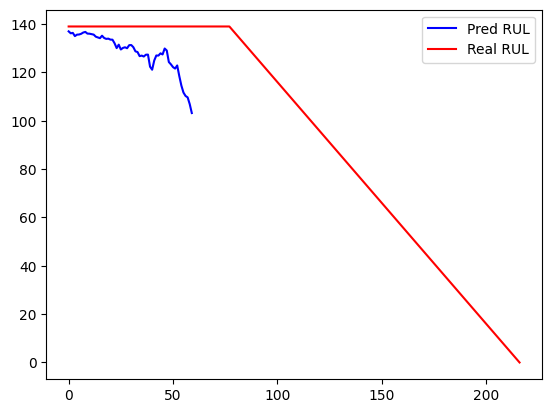

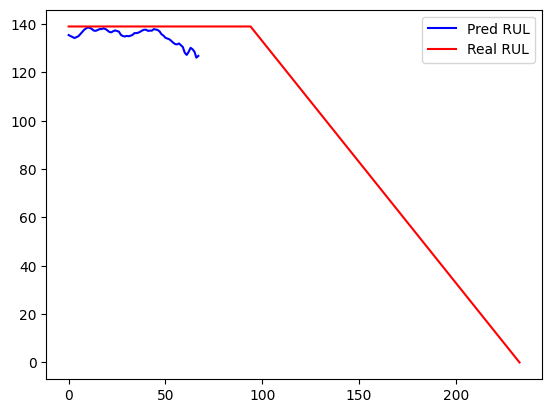

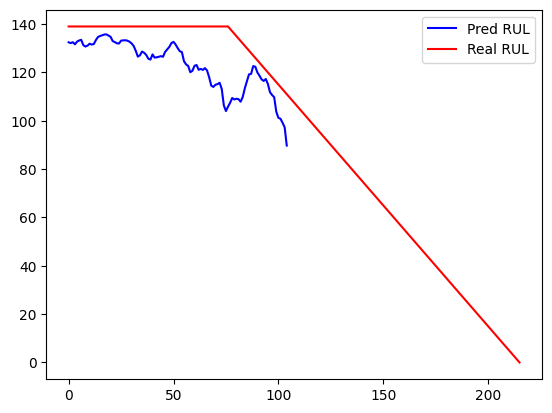

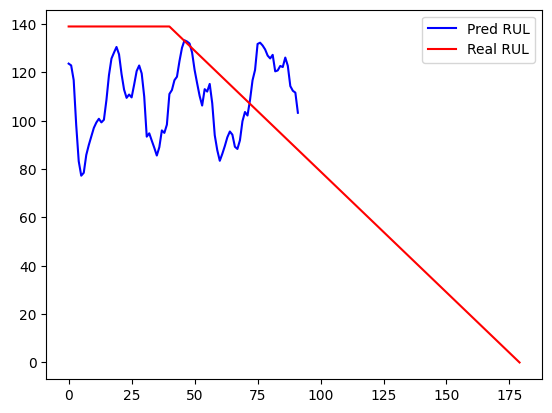

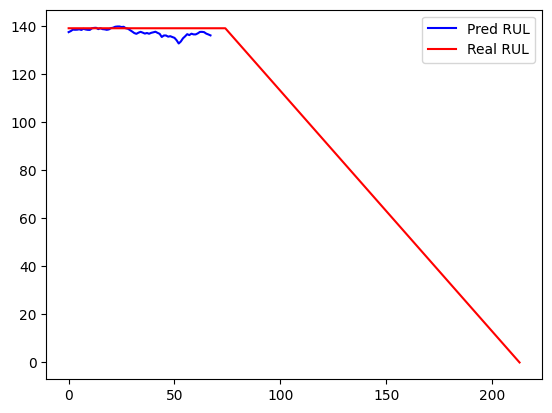

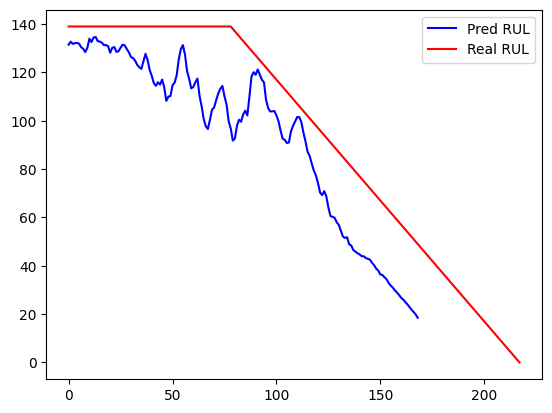

In [171]:
from numpy.lib.stride_tricks import sliding_window_view
for i in range(1,101):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    # print(temp_test_data.shape)
    # 使用 sliding_window_view 取得滑動視圖
    temp_test_data_win = sliding_window_view(temp_test_data, (window_length, 14)).squeeze()
    # print(temp_test_data_win.shape)
    # print(model(temp_test_data_win))
    # print(process_targets(true_rul.values[i], early_rul=early_rul))
    
    _pred_rul = model(temp_test_data_win)[:,0]
    _real_rul = process_targets(true_rul.values[i-1][0]+len(temp_test_data), early_rul=early_rul)
    # print(_pred_rul)
    # print(_real_rul)
    
    # 生成 X 軸的數據
    x1 = np.arange(len(_pred_rul))
    x2 = np.arange(len(_real_rul))
    
    # 畫出兩組數據
    plt.plot(x1, _pred_rul, label='Pred RUL', color="blue")  # 3x1 的數據
    plt.plot(x2, _real_rul, label='Real RUL', color="red")  # 10x1 的數據

    # 添加標題與標籤
    # plt.title('Plotting Two Arrays')
    # plt.xlabel('Index')
    # plt.ylabel('Value')

    # 顯示圖例
    plt.legend()

    # 顯示圖形
    plt.show()